In [1]:
import matplotlib.pyplot as plt
from itertools import combinations
from random import random,randint
import numpy as np
from numpy.linalg import matrix_rank
from functools import reduce
from scipy.optimize import minimize
from scipy.linalg import expm,sinm,cosm,lu
from numpy import binary_repr
import time
import heapq
import math
from   matplotlib import cm
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, execute
from qiskit.quantum_info.analysis import average_data
from qiskit import *
from qiskit.quantum_info.operators import Operator
from qiskit.aqua.utils import tensorproduct
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from qiskit.providers.ibmq      import least_busy
from qiskit.tools.monitor       import job_monitor
from qiskit.visualization import plot_histogram
import warnings
from docplex.mp.model import Model
from qiskit.optimization import QuadraticProgram
from qiskit.optimization.algorithms import CplexOptimizer
import scipy.linalg as la
from itertools import permutations, combinations
import pandas as pd

In [2]:

np.set_printoptions(threshold=sys.maxsize)

X = np.array([[0,1],[1,0]])
Z = np.array([[1,0],[0,-1]])
I = np.array([[1,0],[0,1]])






def StatetoVec(s):
    l = len(s)
    v = np.zeros(2**l)
    index = 0
    for i in range(l):
        index += s[i]*(2**(l-i-1))
    v[index] = 1
    return np.array(v)

def StatetoVecM(s):
    l = len(s)
    v = np.zeros(2**l)
    index = 0
    for i in range(l):
        index += s[i]*(2**(l-i-1))
    v[index] = -1
    return np.array(v)


def TensorProduct(l):
    temp = l[0]
    for i in range(len(l) - 1):
        temp = np.kron(temp,l[i+1])
    return temp

def Stabilizer_513():
    l = []
    stab = []
    l.append(X)
    l.append(Z)
    l.append(Z)
    l.append(X)
    l.append(I)
    stab.append(TensorProduct(l))
    for i in range(3):
        temp = l[4]
        l.pop(4)
        l.insert(0,temp)
        stab.append(TensorProduct(l))
    return stab
        
    
def Lambda(n):
    li = []
    for i in range(n):
        l = []
        for j in range(2*n):
            l.append(0)
        l[i+n] = 1
        li.append(l)
    for i in range(n):
        l = []
        for j in range(2*n):
            l.append(0)
        l[i] = 1
        li.append(l)
    return np.array(li)
        
        
    
def num_1_pos(d):
    get_indexes = lambda x, xs: [i for (y, i) in zip(xs, range(len(xs))) if x == y]
    num_1 = get_indexes(1,d)
    return num_1,len(num_1)

def num_0_pos(d):
    get_indexes = lambda x, xs: [i for (y, i) in zip(xs, range(len(xs))) if x == y]
    num_0 = get_indexes(0,d)
    return num_0,len(num_0)

def column(matrix, i):
    return [row[i] for row in matrix]

#Construct initial state 
def init_s(n):
    x = pow(2,n)
    s = 1/np.sqrt(x) * np.ones(x)
    s = s.reshape(x, 1)
    return s

def bin2dec(string_num):
    return str(int(string_num, 2))

def row_binary(v):
    for i in range(len(v)):
        if v[i]%2 == 0:
            v[i] = 0
        else:
            v[i] = 1 
    return v

def converter(d):
    P = 0
    for i in range(len(d)):
        P+=d[i]*(2**(len(d)-i-1))
    return P
                 
#Define some pauli operators
PauliX = [[0,1],[1,0]]   
PauliZ = [[1,0],[0,-1]]
PauliI = np.eye(2)

#Define Cjk and B
def Cjk_generator(d):
    n = len(d)
    l = list(range(0,n))    
    for i in range(n):
        l[i] = PauliI
    s = num_1_pos(d)[0]
    for j in range(len(s)):
        l[s[j]] = PauliZ
    Cjk = l[0]
    for i in range(n-1):
        Cjk = np.kron(Cjk,l[i+1])
    return Cjk

def B_generator(n):
    l = list(range(0,n))
    b = list(range(0,n))
    
    for a in range(n):
        for i in range(n):
            l[i] = PauliI
        l[a]=PauliX
        temp = l[0]
        for i in range(n-1):
            temp = np.kron(temp,l[i+1])
        b[a] = temp
    B = sum(b[a] for a in range(n))
    return B

def basis(n):
    nums = np.array([a for a in range(2**(n))]) 
    bin_nums = (((nums.reshape(-1,1) & (2**np.arange(n)))) != 0).astype(int)
    a = bin_nums[:,::-1]
    return a


def matrix_binary(A):
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            if A[i][j]%2 == 0:
                A[i][j] = 0
            else:
                A[i][j] = 1
    return A

def error(n,err):
    e = np.zeros(n)
    a = np.random.randint(n,size=err)
    for i in range(len(a)):
        e[a[i]] = 1 
    return e
    


def min_weight(n):
    l = list(range(0,n))
    b = list(range(0,n))
    
    for a in range(n):
        for i in range(n):
            l[i] = PauliI
        l[a]=PauliZ
        temp = l[0]
        for i in range(n-1):
            temp = np.kron(temp,l[i+1])
        b[a] = temp
    min_weight = sum(b[a] for a in range(n))
    return min_weight

def tensorI(n):
    l = list(range(0,n))
    for i in range(n):
            l[i] = PauliI
    temp = l[0]
    for i in range(n-1):
        temp = np.kron(temp,l[i+1])
    return temp 
   


    
    
    
    
    
    

## 513 Stabilizer Code

In [3]:
H_oringin = np.array([[1,0,0,1,0,0,1,1,0,0],[0,1,0,0,1,0,0,1,1,0],[0,0,1,1,0,0,1,1,1,1],[0,1,0,1,0,1,0,0,0,1]])
H_oringinT = H_oringin.T

L = Lambda(5)

G = np.array([[1,0,0,0,1,1,1,0,1,1],[0,1,0,0,1,0,0,1,1,0],[0,0,1,0,1,1,1,0,0,0],[0,0,0,1,1,1,0,1,1,1],
              [0,0,0,0,1,1,0,0,1,0],[0,0,0,0,0,1,1,1,1,1]])


M = H_oringin.dot(L)





x = np.array([1,0,0,0,1,1,1,0,1,1])
err = []
for i in range(10):
    l = np.zeros(10)
    l[i] = 1
    err.append(l)
for i in range(5):
    l = np.zeros(10)
    l[i] = 1
    l[i+5] = 1
    err.append(l)
err = np.array(err)

error_syndrome = []
for i in range(len(err)):
    sy = row_binary(M.dot((x + err[i]).T))
    print('\nerror: ',err[i])
    print('syndrome: ',sy)





error:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
syndrome:  [0. 0. 0. 1.]

error:  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
syndrome:  [1. 0. 1. 0.]

error:  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
syndrome:  [1. 1. 1. 0.]

error:  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
syndrome:  [0. 1. 1. 0.]

error:  [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
syndrome:  [0. 0. 1. 1.]

error:  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
syndrome:  [1. 0. 0. 0.]

error:  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
syndrome:  [0. 1. 0. 1.]

error:  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
syndrome:  [0. 0. 1. 0.]

error:  [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
syndrome:  [1. 0. 1. 1.]

error:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
syndrome:  [0. 1. 0. 0.]

error:  [1. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
syndrome:  [1. 0. 0. 1.]

error:  [0. 1. 0. 0. 0. 0. 1. 0. 0. 0.]
syndrome:  [1. 1. 1. 1.]

error:  [0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
syndrome:  [1. 1. 0. 0.]

error:  [0. 0. 0. 1. 0. 0. 0. 0. 1. 0.]
syndrome:  [1. 1. 0. 1.]

error:  [0. 0. 0. 0. 1. 0. 0. 0. 0. 1.]
syndrome:  [0. 1. 1. 1.]


## QAOA  p = 0

error:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

syndrome: [0. 0. 0. 1.]

 Runningtime :  1293.8490161895752 sec

estimate error :
 [[0 1 0 0 0 0 0 0 1 0]
 [0 1 1 0 0 0 1 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 1]
 [0 0 1 0 0 0 0 0 1 1]
 [1 0 1 0 0 0 1 0 1 0]
 [0 1 1 1 1 0 0 0 0 0]
 [0 1 0 1 1 0 1 0 1 0]]

check
 [[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0.]]


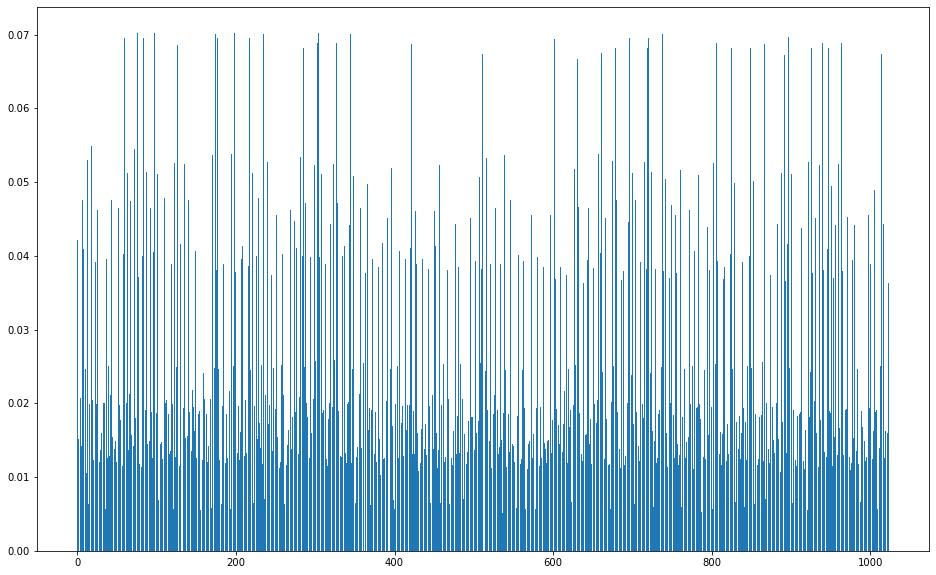

error:  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]

syndrome: [1. 0. 1. 0.]

 Runningtime :  1296.9623882770538 sec

estimate error :
 [[0 1 0 0 0 0 0 0 0 0]
 [0 1 1 0 0 0 1 0 1 0]
 [0 0 1 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 1 0]
 [1 0 1 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 1 0 1 1]
 [0 1 1 1 1 0 0 0 1 0]
 [0 1 0 1 1 0 1 0 0 0]]

check
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1. 0.]]


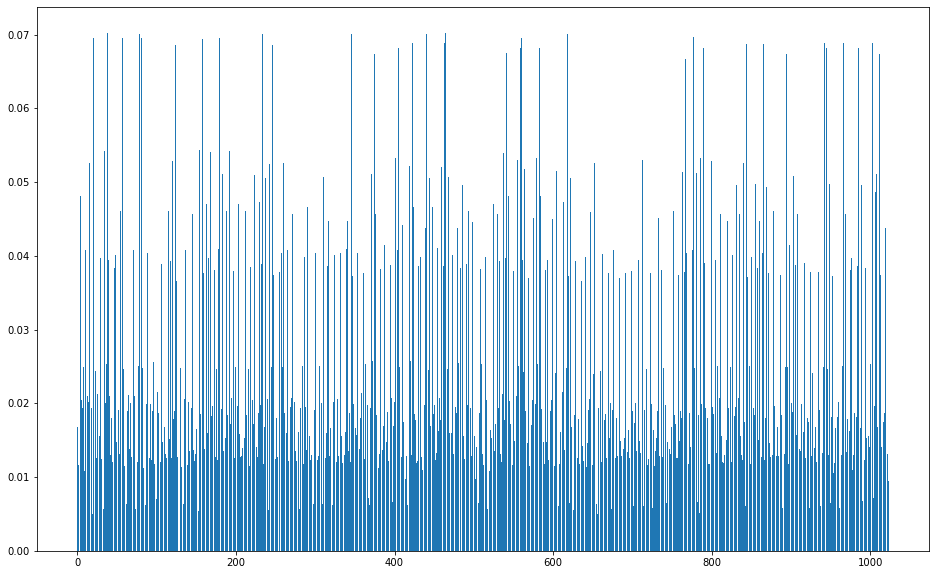

error:  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]

syndrome: [1. 1. 1. 0.]

 Runningtime :  1295.8591809272766 sec

estimate error :
 [[0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 1 0]
 [0 0 0 1 1 0 0 0 1 0]
 [0 0 1 1 1 0 1 0 0 0]
 [0 1 0 0 0 0 0 0 0 1]
 [1 1 1 0 0 0 0 0 1 0]
 [1 1 0 0 0 0 1 0 0 0]
 [0 1 1 0 0 0 1 0 1 1]]

check
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1. 1.]]


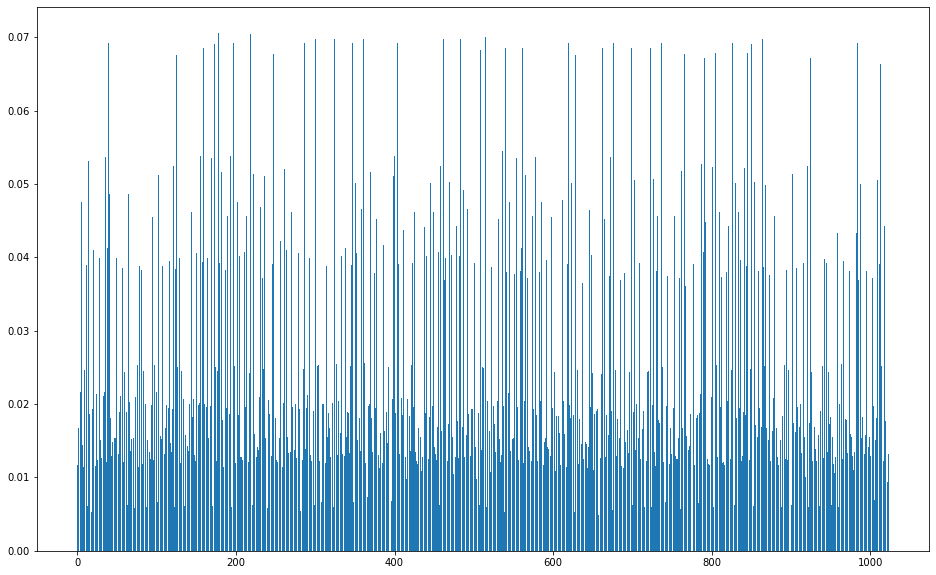

error:  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]

syndrome: [0. 1. 1. 0.]

 Runningtime :  1298.697681427002 sec

estimate error :
 [[0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0 0 1 0]
 [0 0 1 1 0 0 1 0 1 0]
 [0 0 1 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 1 0 1 0]
 [0 1 1 0 0 0 0 1 0 0]
 [0 1 1 1 0 0 0 0 0 1]]

check
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1. 0.]]


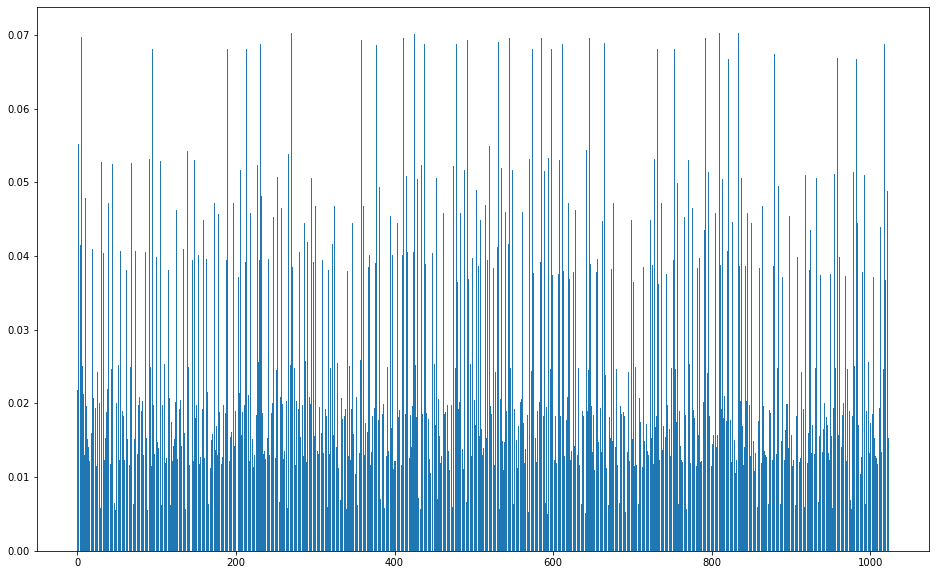

error:  [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]

syndrome: [0. 0. 1. 1.]

 Runningtime :  1298.377735376358 sec

estimate error :
 [[0 0 0 0 1 0 0 0 0 0]
 [0 0 0 1 0 0 1 0 0 0]
 [0 0 1 1 0 0 0 0 1 0]
 [0 0 1 0 1 0 1 0 1 0]
 [0 0 0 0 0 1 0 0 1 0]
 [0 0 1 0 0 1 1 0 0 0]
 [0 1 0 0 0 0 0 1 1 0]
 [1 1 0 0 1 0 0 0 1 0]]

check
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]]


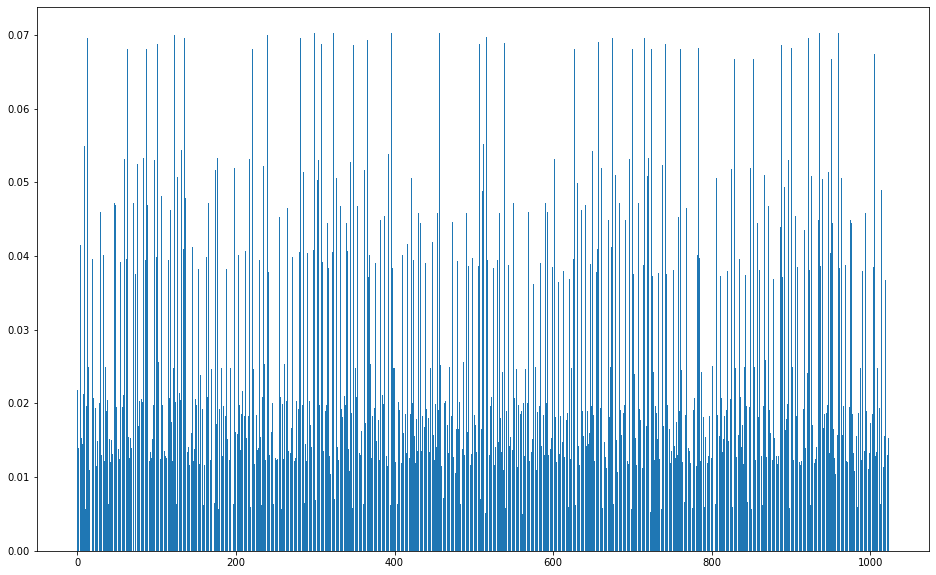

error:  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]

syndrome: [1. 0. 0. 0.]

 Runningtime :  1310.639846086502 sec

estimate error :
 [[0 0 0 0 1 0 0 0 1 0]
 [0 0 1 1 0 0 0 0 0 0]
 [0 0 1 0 1 0 1 0 0 0]
 [0 0 0 1 0 0 1 0 1 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 1 0 0 1 1 0 1 0]
 [0 1 0 0 0 0 0 1 0 0]
 [1 1 0 0 1 0 0 0 0 0]]

check
 [[0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 1.]]


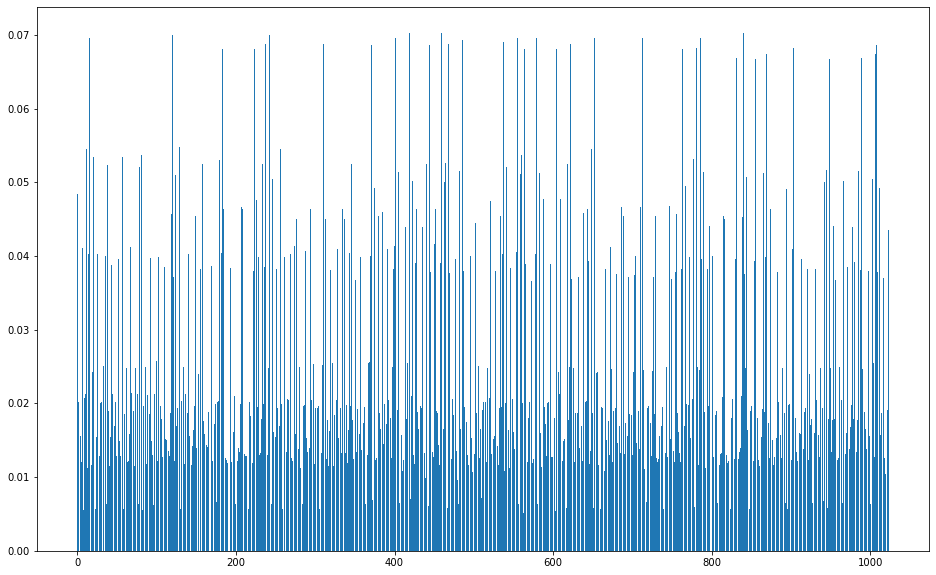

error:  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]

syndrome: [0. 1. 0. 1.]

 Runningtime :  1296.9895267486572 sec

estimate error :
 [[0 0 0 0 0 0 1 0 0 0]
 [0 0 1 0 0 0 0 0 1 0]
 [0 0 0 1 1 0 0 0 0 0]
 [0 0 1 1 1 0 1 0 1 0]
 [1 1 1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 1 1]
 [1 1 0 0 0 0 1 0 1 0]
 [0 1 1 0 0 0 1 0 0 1]]

check
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]]


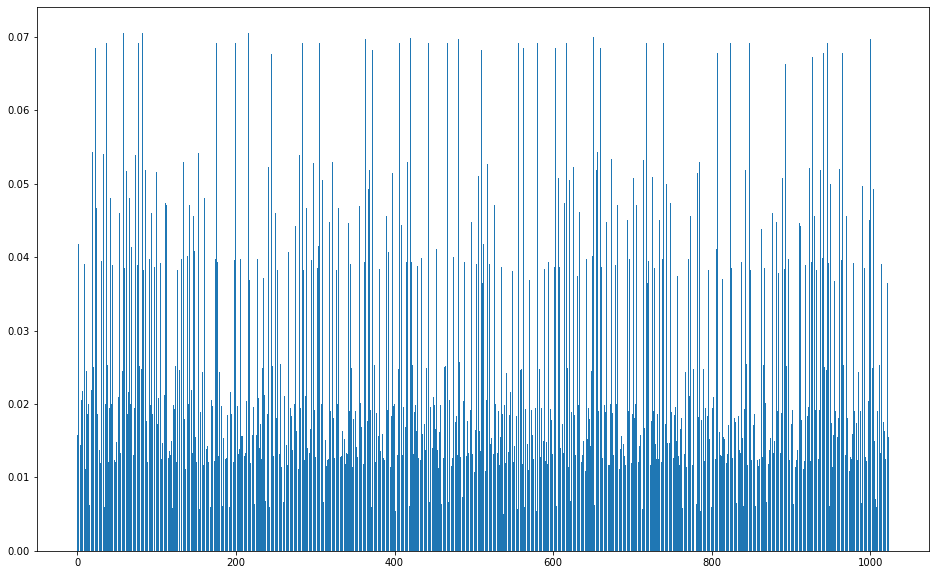

error:  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]

syndrome: [0. 0. 1. 0.]

 Runningtime :  1296.8172359466553 sec

estimate error :
 [[0 1 0 0 1 0 0 0 1 0]
 [0 1 1 1 0 0 0 0 0 0]
 [0 1 0 1 0 0 1 0 1 0]
 [0 1 1 0 1 0 1 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [1 0 0 0 1 0 0 0 0 0]
 [0 1 0 0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 1]]

check
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]]


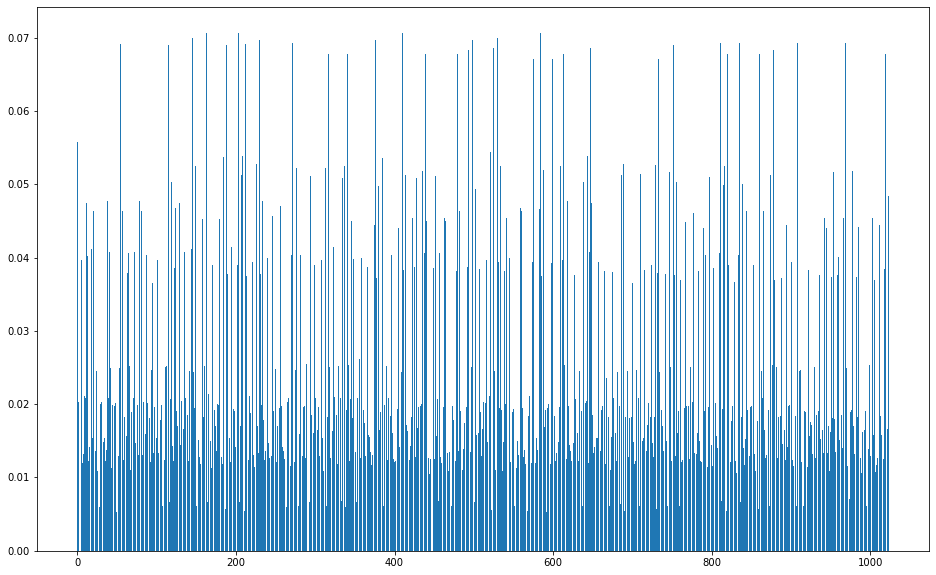

error:  [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]

syndrome: [1. 0. 1. 1.]

 Runningtime :  1296.190686225891 sec

estimate error :
 [[0 0 0 0 0 0 0 0 1 0]
 [0 0 1 0 0 0 1 0 0 0]
 [0 0 1 1 1 0 0 0 0 0]
 [0 0 0 1 1 0 1 0 1 0]
 [1 1 0 0 0 0 0 0 0 0]
 [0 1 1 0 0 0 0 0 1 1]
 [0 1 0 0 0 0 1 0 0 1]
 [1 1 1 0 0 0 1 0 1 0]]

check
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1. 1.]]


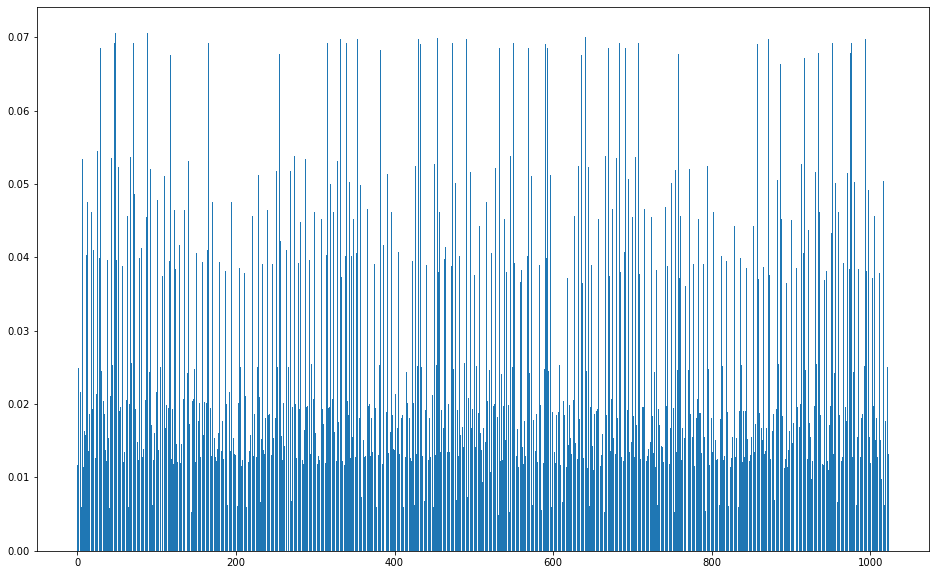

error:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]

syndrome: [0. 1. 0. 0.]

 Runningtime :  1298.0262024402618 sec

estimate error :
 [[0 1 1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 1 0 1 0]
 [0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 1 0 0 0]
 [1 0 1 0 0 0 0 0 1 0]
 [0 0 1 0 0 0 1 0 1 1]
 [0 1 0 1 1 0 0 0 1 0]
 [0 1 1 1 1 0 1 0 0 0]]

check
 [[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0.]]


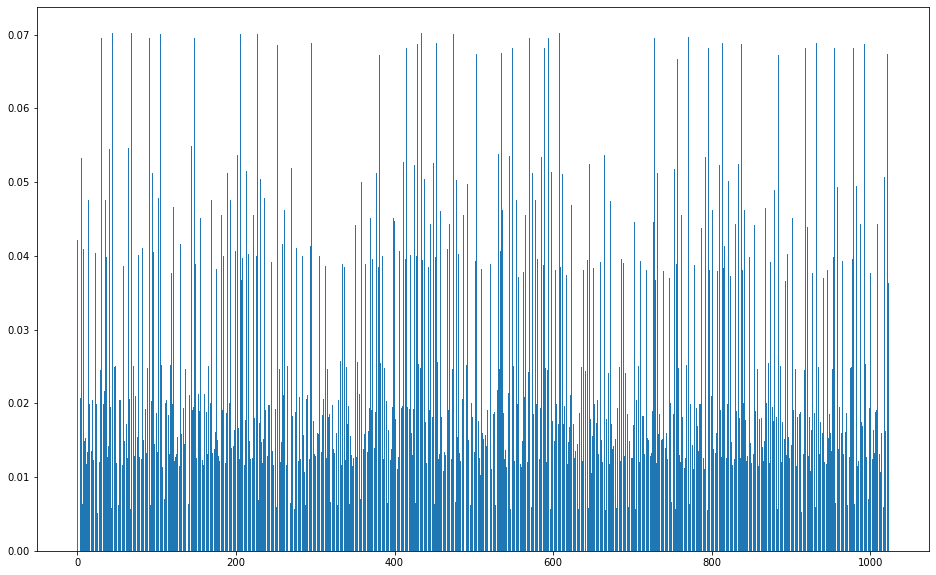

error:  [1. 0. 0. 0. 0. 1. 0. 0. 0. 0.]

syndrome: [1. 0. 0. 1.]

 Runningtime :  1296.851039648056 sec

estimate error :
 [[0 1 0 0 1 0 0 0 0 0]
 [0 1 1 1 0 0 0 0 1 0]
 [0 1 0 1 0 0 1 0 0 0]
 [0 1 1 0 1 0 1 0 1 0]
 [1 0 0 0 1 0 0 0 1 0]
 [0 1 0 0 0 1 0 0 1 0]
 [0 0 0 0 0 0 0 1 1 0]
 [0 0 1 1 0 0 1 0 0 1]]

check
 [[0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1. 1.]]


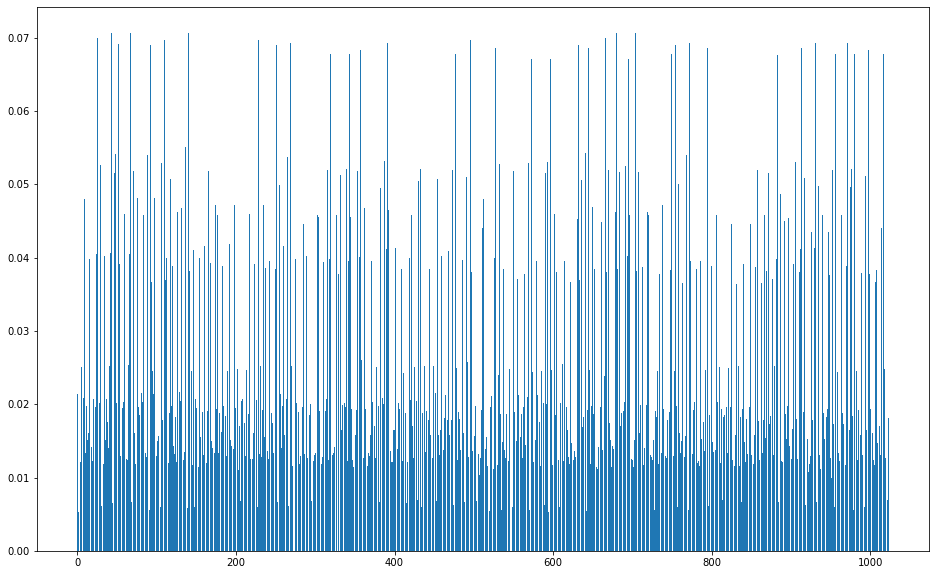

error:  [0. 1. 0. 0. 0. 0. 1. 0. 0. 0.]

syndrome: [1. 1. 1. 1.]

 Runningtime :  1297.0775473117828 sec

estimate error :
 [[0 1 1 0 0 0 0 0 1 0]
 [0 1 0 0 0 0 1 0 0 0]
 [1 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1]
 [1 0 0 0 0 0 1 0 1 0]
 [0 0 1 0 0 0 1 0 0 1]
 [0 1 0 1 1 0 0 0 0 0]
 [0 1 1 1 1 0 1 0 1 0]]

check
 [[0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 1.]]


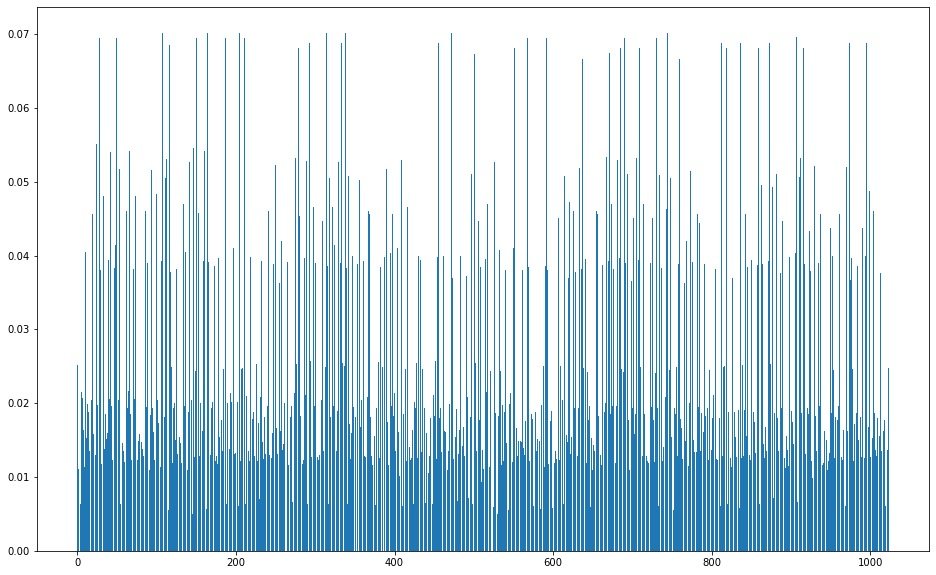

error:  [0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]

syndrome: [1. 1. 0. 0.]

 Runningtime :  1296.3912003040314 sec

estimate error :
 [[0 1 0 1 0 0 0 0 0 0]
 [0 1 1 0 1 0 0 0 1 0]
 [0 1 0 0 1 0 1 0 0 0]
 [0 1 1 1 0 0 1 0 1 0]
 [0 1 1 0 0 1 0 0 0 0]
 [0 0 1 1 0 0 0 0 0 1]
 [0 0 1 0 0 0 0 1 0 0]
 [1 0 0 0 1 0 1 0 1 0]]

check
 [[0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1.]]


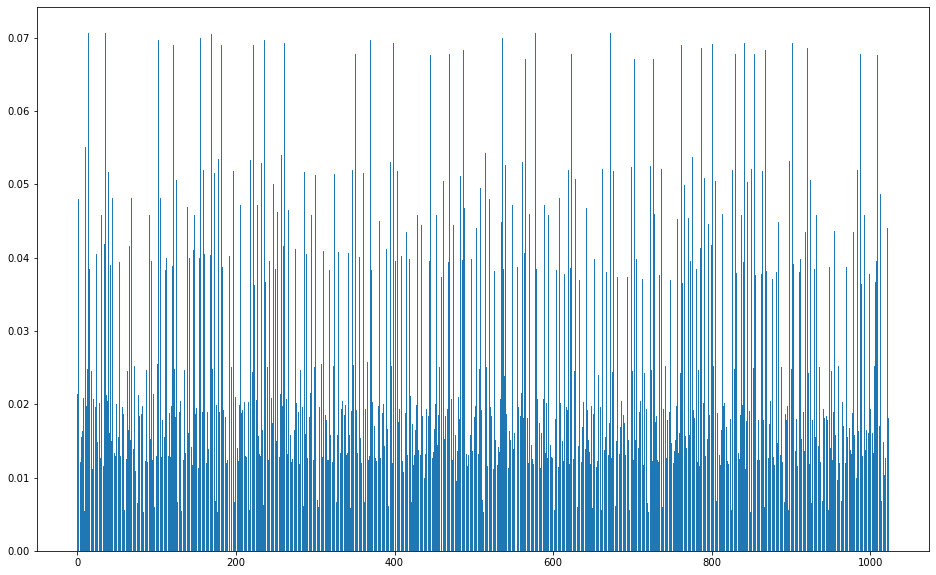

error:  [0. 0. 0. 1. 0. 0. 0. 0. 1. 0.]

syndrome: [1. 1. 0. 1.]

 Runningtime :  1296.5396890640259 sec

estimate error :
 [[0 0 0 1 0 0 0 0 1 0]
 [0 0 1 0 1 0 0 0 0 0]
 [0 0 0 0 1 0 1 0 1 0]
 [0 0 1 1 0 0 1 0 0 0]
 [0 0 1 0 0 1 0 0 1 0]
 [0 0 0 0 0 1 1 0 0 0]
 [0 1 1 0 0 0 0 1 1 0]
 [1 1 1 0 1 0 0 0 1 0]]

check
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1.]]


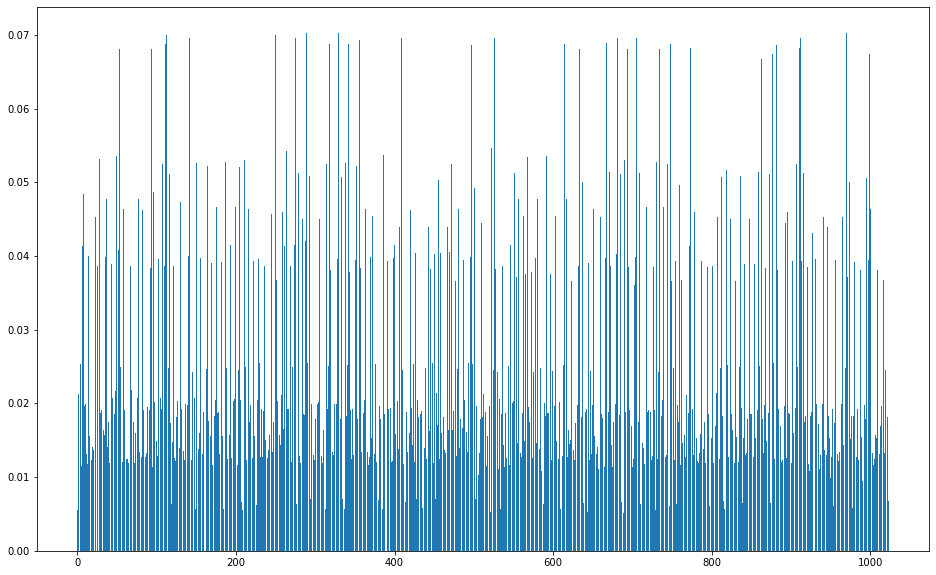

error:  [0. 0. 0. 0. 1. 0. 0. 0. 0. 1.]

syndrome: [0. 1. 1. 1.]

 Runningtime :  1297.8896503448486 sec

estimate error :
 [[0 1 0 1 0 0 0 0 1 0]
 [0 1 1 0 1 0 0 0 0 0]
 [0 1 1 1 0 0 1 0 0 0]
 [0 1 0 0 1 0 1 0 1 0]
 [0 1 1 0 0 1 0 0 1 0]
 [1 0 0 0 1 0 1 0 0 0]
 [0 0 0 1 0 0 1 0 0 1]
 [1 0 0 1 0 0 0 0 0 0]]

check
 [[0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 1.]]


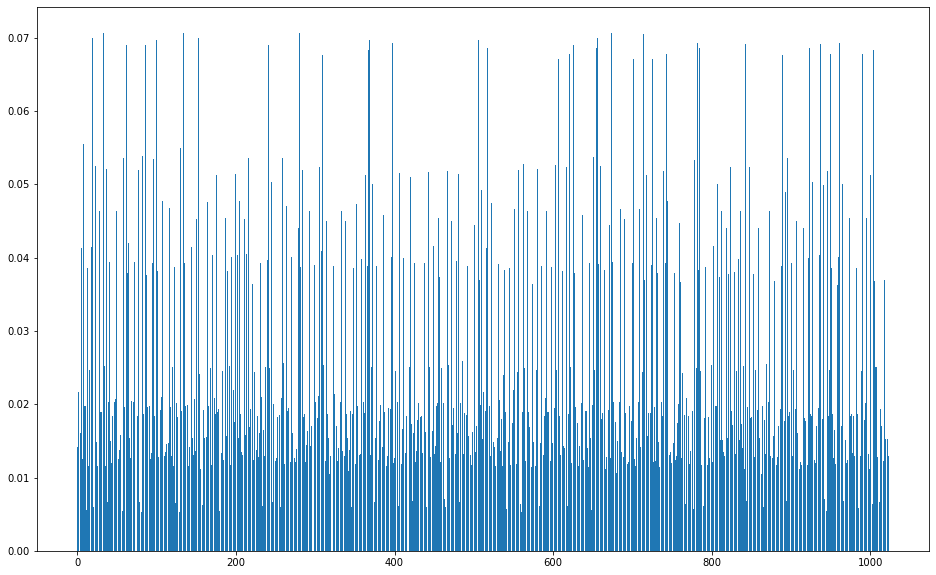

In [7]:
probability = []
gamma = []
beta = []
syndrome = []

num = int(M.shape[1]/2)

min_weight_term = np.kron(min_weight(num),tensorI(num)) + np.kron(tensorI(num),min_weight(num))

for d in range(len(err)):    
    p = 0.01
    n = M.shape[1]
    print('error: ', err[d])
    syndr = row_binary(M.dot(err[d]))
    C = (sum((1-2*syndr[a])*Cjk_generator(M[a]) for a in range(M.shape[0]))) + p * min_weight_term
    B = B_generator(M.shape[1])
    s = init_s(n)
    s_d = (s).T
    print('\nsyndrome:',syndr)
    #print("the number of basis",k+1)

    #run the program
    start_time = time.time()
    step_size   = 0.1
    result_array = np.zeros(shape=(int(3.14/step_size)+1, int(3.14/step_size)+1))
    a_gamma         = np.arange(0, np.pi, step_size)
    a_beta          = np.arange(0, np.pi, step_size)

    f_p_max = 0
    f_p_max_gamma = 0
    f_p_max_beta = 0
    f_psum = 0

    for i in range(0, int(3.14/step_size)+1):           # i for a_gamma
        for j in range(0, int(3.14/step_size)+1):       # j for a_beta

            #Construct U_C
            U_C = np.asmatrix(expm(-1j*2*a_gamma[i]*C))
            #Construct U_B
            U_B = expm(-1j*a_beta[j]*B)


            #Construct expection of each subgraph
            state = (U_B.dot(U_C)).dot(s).reshape(pow(2,n),1) # ket
            state_d = (state.conjugate()).T # bra


            f_p = (state_d.dot(C)).dot(state)
            f_psum += f_p

            if f_p.real > f_p_max:
                f_p_max = f_p.real
                f_p_max_gamma = a_gamma[i]
                f_p_max_beta = a_beta[j]

            result_array[i][j] = f_p.real
#         print("\n Average expectation using QAOA with fine grid : ",(f_psum/pow(len(a_gamma),2)).real)       
#         print("\n Maximum expectation using QAOA with fine grid : ",f_p_max)
#         print("\n Optimal gamma : ",f_p_max_gamma)
#         print("\n Optimal beta : ",f_p_max_beta)


    end_time = time.time()
    print("\n Runningtime : ",end_time - start_time,"sec")
    r = np.ones(2**M.shape[1])/(np.sqrt(2**M.shape[1]))
    #Construct U_C
    U_C = np.asmatrix(expm(-1j*2*f_p_max_gamma*C))
    #Construct U_B
    U_B = expm(-1j*f_p_max_beta*B)
    gamma.append(f_p_max_gamma)
    beta.append(f_p_max_beta)

    #Construct expection of each subgraph
    state = (U_B.dot(U_C)).dot(r).reshape(pow(2,n),1) # ket
    prob=[]
    for i in range(len(state)):
        p = np.sqrt((state[i].real)**2 + (state[i].imag)**2)
        np.array(prob.append(float(p)))      
    e = np.max(prob)
    probability.append(prob)
    max_number = heapq.nlargest(8, prob) 
    max_index = []
    for t in max_number:
        index = prob.index(t)
        max_index.append(index)
        prob[index] = 0
    Ba = basis(n)
    word = []
    for a in range(len(max_index)):
        word.append(Ba[(max_index[a])])
    print('\nestimate error :\n',(np.array(word)))
    err_8 = []
    for q in range(8):
          err_8.append(err[d])
   
    
    check  = matrix_binary(((np.array(word) - np.array(err_8)).dot(L)).dot(G.T))
    
    print('\ncheck\n' ,check)
   
    plt.rcParams['figure.figsize'] = [16, 10]
    plt.bar(range(0, len(state)),prob)
    plt.show()
   
    
    
    
    
    


In [8]:
pr = {'probability':probability[8]}
dfpr = pd.DataFrame(data = pr)
dfpr.sort_values(by = ['probability'], ascending = False)


,probability
48,0.070555
210,0.070516
88,0.070498
186,0.070457
641,0.070088
...,...
224,0.000000
906,0.000000
265,0.000000
2,0.000000


In [9]:
d = {'gamma': gamma,'beta ': beta}
df = pd.DataFrame(data = d)
df   #all are (1.8,0.2) when p = 0

,gamma,beta
0,1.8,0.2
1,1.8,0.2
2,1.8,0.2
3,1.8,0.2
4,1.8,0.2
5,1.8,0.2
6,1.8,0.2
7,1.8,0.2
8,1.8,0.2
9,1.8,0.2


## QAOA p = 0.5

syndrome: [0 0 0 0]

 Runningtime :  1345.5631527900696 sec


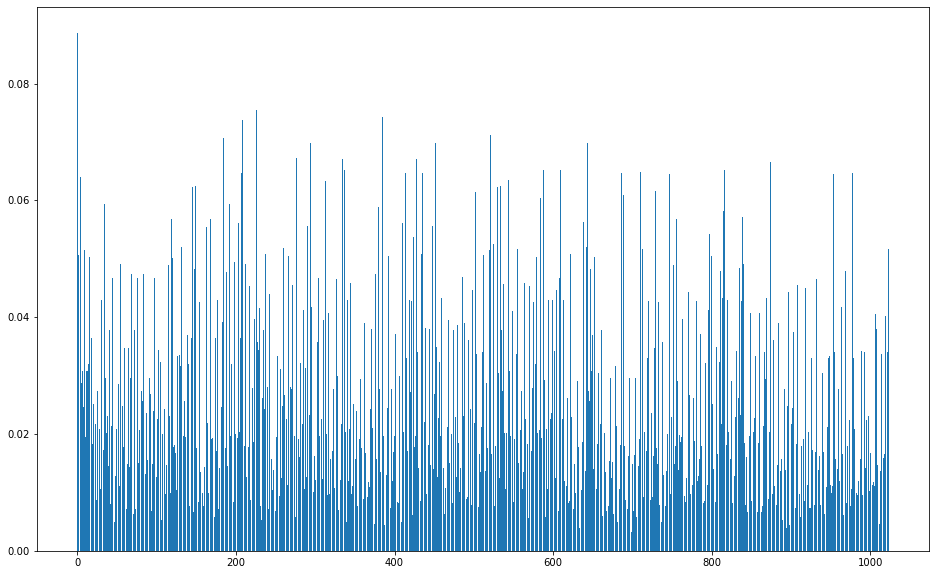

[[0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 1 0 1 0]
 [0 0 1 1 1 0 0 0 1 0]
 [0 0 0 1 1 0 1 0 0 0]
 [1 1 0 0 0 0 0 0 1 0]
 [0 1 1 0 0 0 0 0 0 1]
 [0 0 1 1 0 1 0 0 0 0]
 [0 0 0 0 1 1 0 0 1 0]]
$$$$$$$$$$$$$$$$$$$$$
syndrome: [0 0 0 1]

 Runningtime :  1339.6730723381042 sec


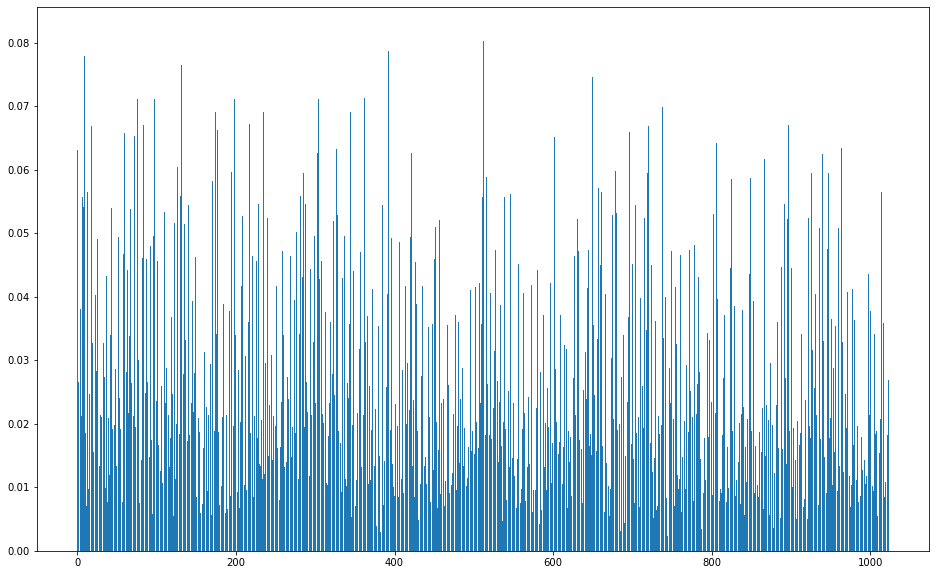

[[0 1 0 0 0 0 0 0 1 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 1 1 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 1 0 0 1]
 [0 0 1 0 0 0 0 0 1 1]
 [1 0 1 0 0 0 1 0 1 0]
 [0 0 0 0 1 0 0 1 0 0]
 [0 1 1 1 1 0 0 0 0 0]]
$$$$$$$$$$$$$$$$$$$$$
syndrome: [0 0 1 0]

 Runningtime :  1341.1410479545593 sec


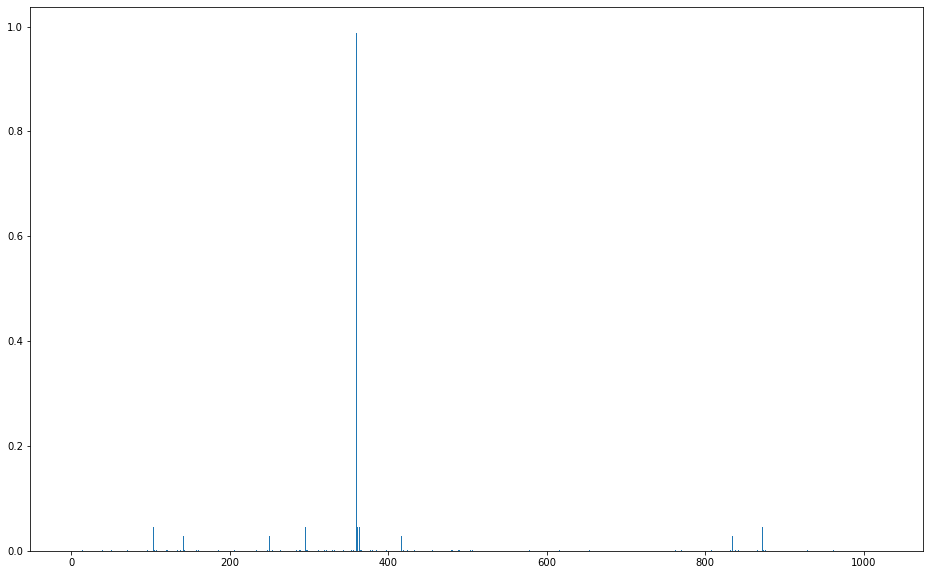

[[0 1 0 1 1 0 1 0 0 0]
 [0 1 0 1 1 0 0 0 0 0]
 [1 1 0 1 1 0 1 0 0 0]
 [0 1 0 1 1 0 1 0 0 1]
 [0 1 0 1 0 0 1 0 0 0]
 [0 1 0 0 1 0 1 0 0 0]
 [0 1 0 1 1 0 1 1 0 0]
 [0 1 0 1 1 0 1 0 1 0]]
$$$$$$$$$$$$$$$$$$$$$
syndrome: [0 0 1 1]

 Runningtime :  1340.1401166915894 sec


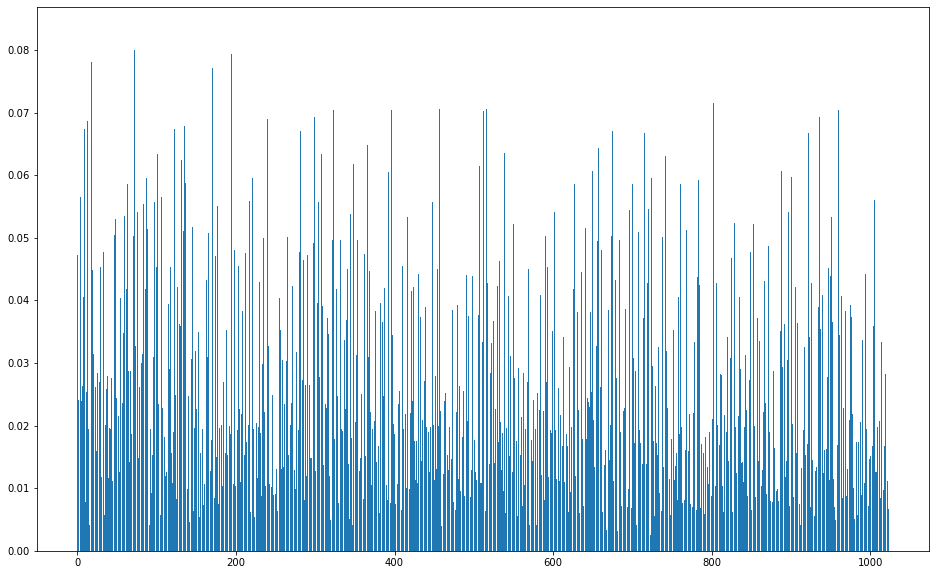

[[0 0 0 0 1 0 0 0 0 0]
 [0 0 0 1 0 0 1 0 0 0]
 [0 0 1 1 0 0 0 0 1 0]
 [0 0 0 0 0 1 0 0 1 0]
 [0 0 1 0 1 0 1 0 1 0]
 [0 0 1 0 0 1 1 0 0 0]
 [0 1 0 0 0 0 0 1 1 0]
 [1 1 0 0 1 0 0 0 1 0]]
$$$$$$$$$$$$$$$$$$$$$
syndrome: [0 1 0 0]

 Runningtime :  1343.4780640602112 sec


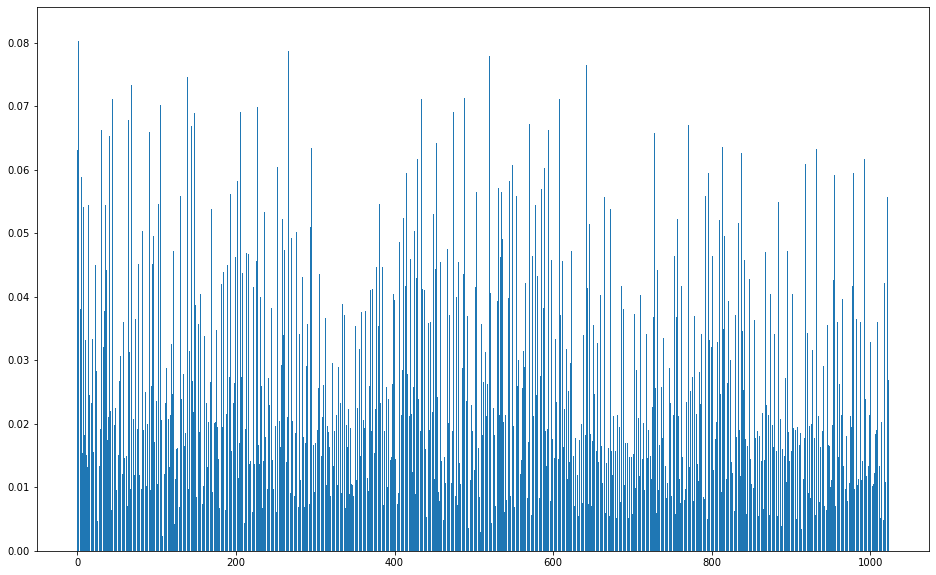

[[0 1 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 1 0 0 0 0 1 0 1 0]
 [1 0 0 0 0 0 1 0 0 0]
 [1 0 1 0 0 0 0 0 1 0]
 [0 0 1 0 0 0 1 0 1 1]
 [0 0 0 1 0 0 0 1 0 0]
 [0 1 0 1 1 0 0 0 1 0]]
$$$$$$$$$$$$$$$$$$$$$
syndrome: [0 1 0 1]

 Runningtime :  1336.2460010051727 sec


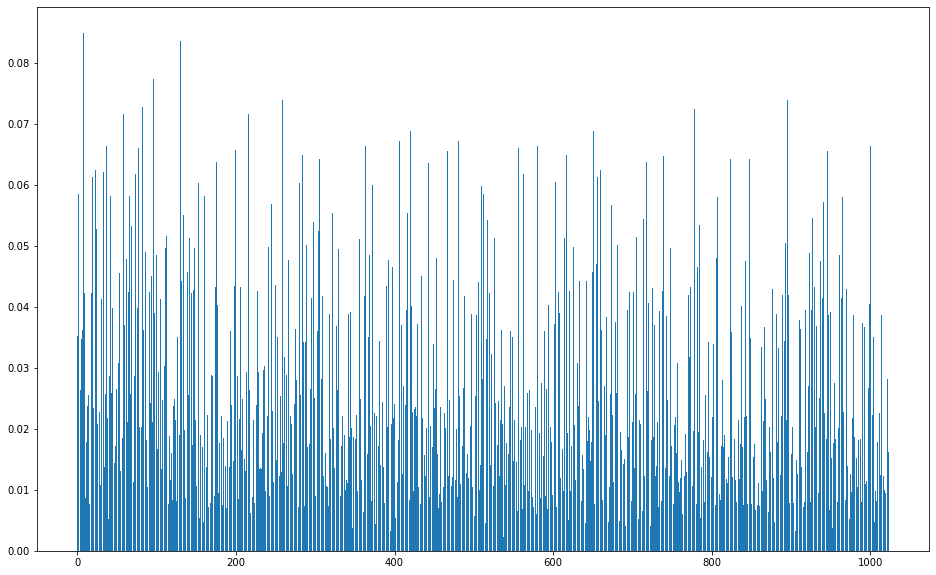

[[0 0 0 0 0 0 1 0 0 0]
 [0 0 1 0 0 0 0 0 1 0]
 [0 0 0 1 1 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 1 1]
 [1 1 1 0 0 0 0 0 0 0]
 [0 0 1 1 1 0 1 0 1 0]
 [0 0 1 0 1 1 0 0 0 0]
 [0 0 0 1 0 1 0 0 1 0]]
$$$$$$$$$$$$$$$$$$$$$
syndrome: [0 1 1 0]

 Runningtime :  1335.3873949050903 sec


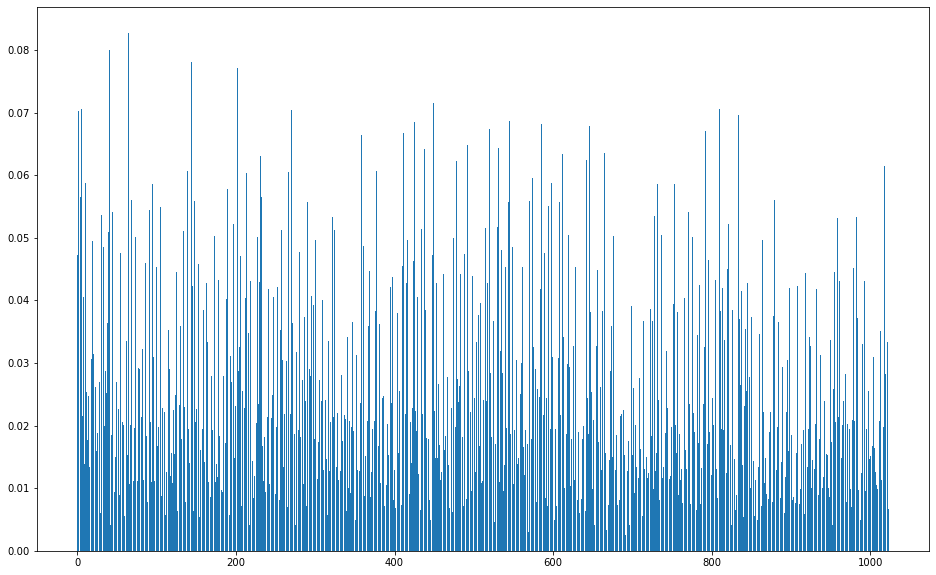

[[0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0 0 1 0]
 [0 0 1 0 0 1 0 0 0 0]
 [0 0 1 1 0 0 1 0 1 0]
 [0 0 0 0 0 1 1 0 1 0]
 [0 1 1 0 0 0 0 1 0 0]
 [0 1 1 1 0 0 0 0 0 1]]
$$$$$$$$$$$$$$$$$$$$$
syndrome: [0 1 1 1]

 Runningtime :  1336.7084112167358 sec


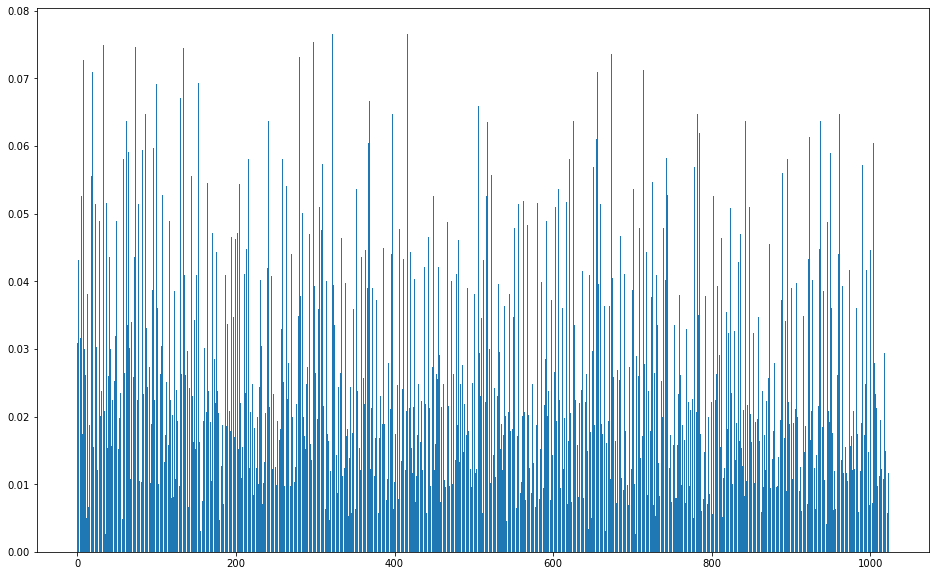

[[0 1 0 1 0 0 0 0 1 0]
 [0 1 1 0 1 0 0 0 0 0]
 [0 1 0 0 1 0 1 0 1 0]
 [0 1 1 1 0 0 1 0 0 0]
 [0 1 1 0 0 1 0 0 1 0]
 [0 0 0 0 0 0 1 1 0 0]
 [1 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 1]]
$$$$$$$$$$$$$$$$$$$$$
syndrome: [1 0 0 0]

 Runningtime :  1335.0886254310608 sec


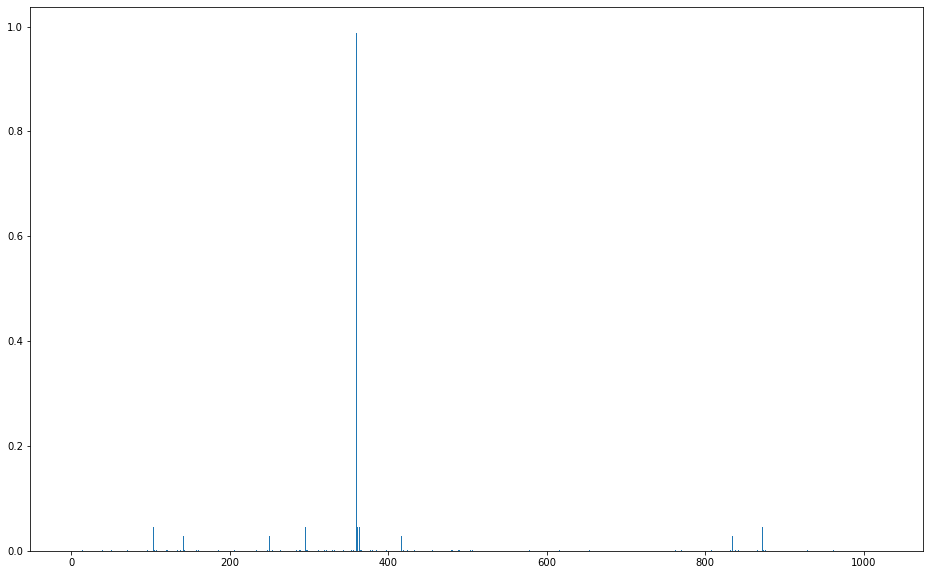

[[0 1 0 1 1 0 1 0 0 0]
 [0 0 0 1 1 0 1 0 0 0]
 [0 1 0 1 1 0 1 0 1 0]
 [0 1 1 1 1 0 1 0 0 0]
 [0 1 0 1 1 1 1 0 0 0]
 [0 1 0 1 1 0 1 0 0 1]
 [1 1 0 1 1 0 1 0 0 0]
 [0 1 0 1 1 0 0 0 0 0]]
$$$$$$$$$$$$$$$$$$$$$
syndrome: [1 0 0 1]

 Runningtime :  1336.6695647239685 sec


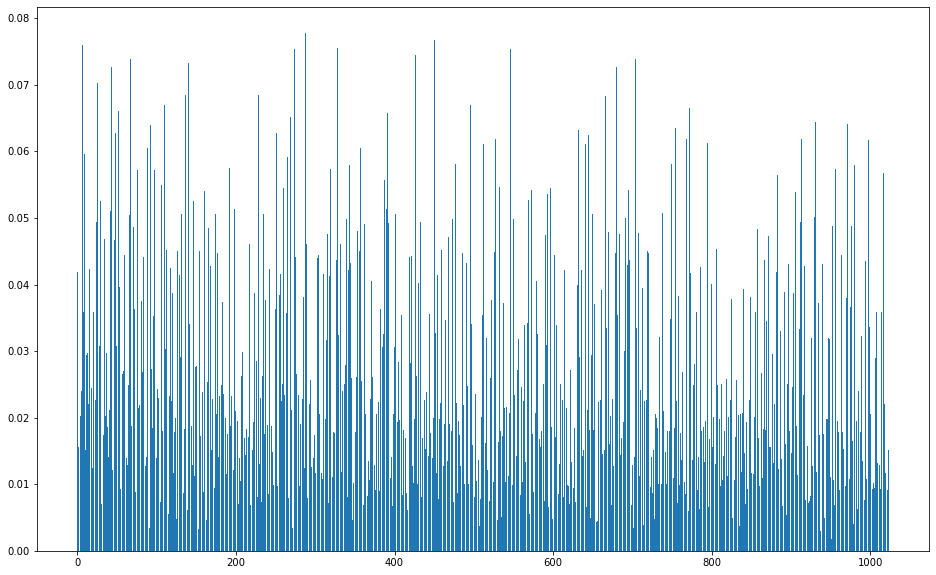

[[0 1 0 0 1 0 0 0 0 0]
 [0 1 1 1 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 1 1 0]
 [0 1 0 1 0 0 1 0 0 0]
 [1 0 0 0 1 0 0 0 1 0]
 [0 1 0 0 0 1 0 0 1 0]
 [0 1 1 0 1 0 1 0 1 0]
 [0 0 1 1 0 0 1 0 0 1]]
$$$$$$$$$$$$$$$$$$$$$
syndrome: [1 0 1 0]

 Runningtime :  1335.709320306778 sec


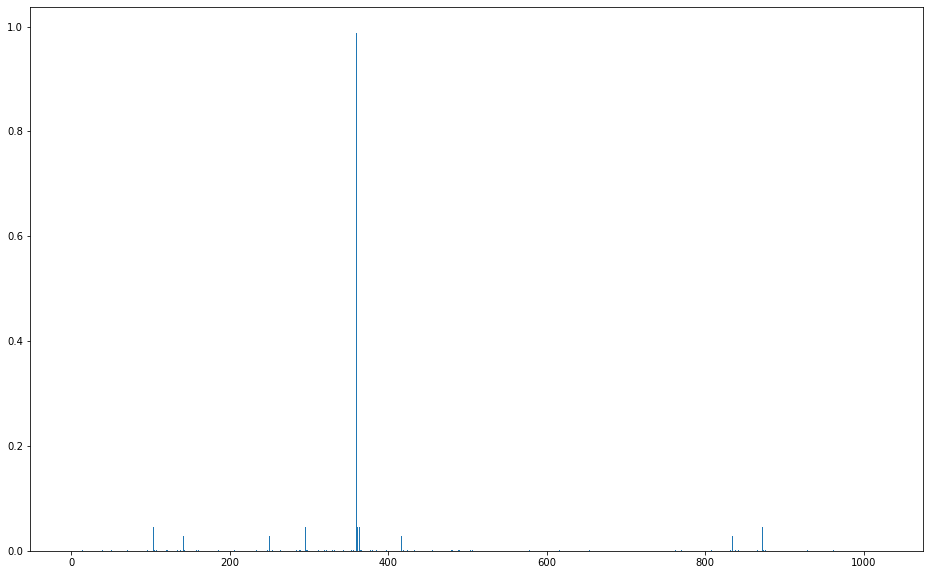

[[0 1 0 1 1 0 1 0 0 0]
 [0 1 0 1 1 1 1 0 0 0]
 [0 1 0 1 1 0 1 0 1 0]
 [0 1 1 1 1 0 1 0 0 0]
 [0 0 0 1 1 0 1 0 0 0]
 [0 1 0 1 0 0 1 0 0 0]
 [0 1 0 0 1 0 1 0 0 0]
 [0 1 0 1 1 0 1 1 0 0]]
$$$$$$$$$$$$$$$$$$$$$
syndrome: [1 0 1 1]

 Runningtime :  1335.694816827774 sec


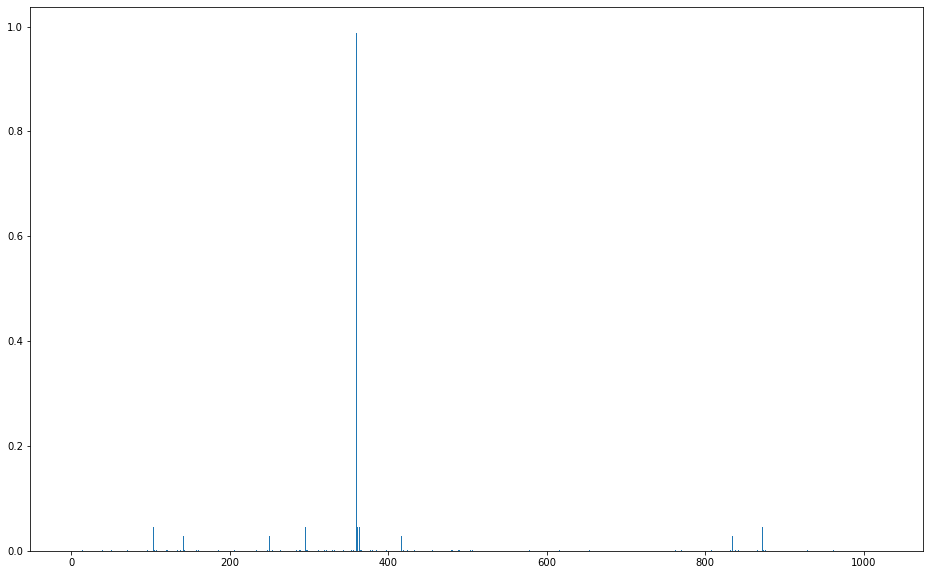

[[0 1 0 1 1 0 1 0 0 0]
 [0 1 0 1 1 1 1 0 0 0]
 [0 0 0 1 1 0 1 0 0 0]
 [0 1 0 1 1 0 1 0 1 0]
 [0 1 1 1 1 0 1 0 0 0]
 [0 1 0 1 1 0 1 1 0 0]
 [0 1 0 0 1 0 1 0 0 0]
 [0 1 0 1 0 0 1 0 0 0]]
$$$$$$$$$$$$$$$$$$$$$
syndrome: [1 1 0 0]

 Runningtime :  1336.1848773956299 sec


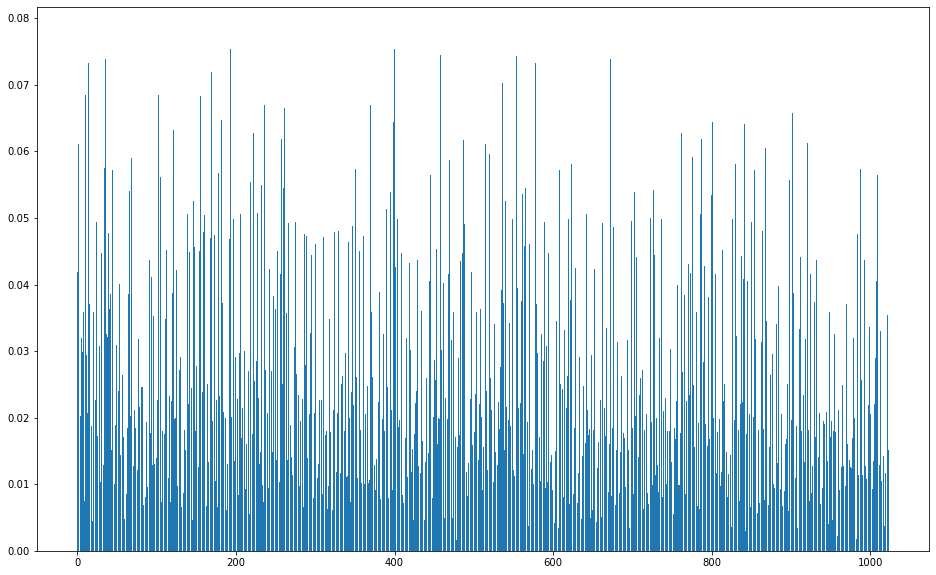

[[0 1 0 1 0 0 0 0 0 0]
 [0 1 1 0 1 0 0 0 1 0]
 [0 0 1 0 0 0 0 1 0 0]
 [0 1 0 0 1 0 1 0 0 0]
 [0 0 1 1 0 0 0 0 0 1]
 [0 1 1 0 0 1 0 0 0 0]
 [0 1 1 1 0 0 1 0 1 0]
 [1 0 0 0 1 0 1 0 1 0]]
$$$$$$$$$$$$$$$$$$$$$
syndrome: [1 1 0 1]

 Runningtime :  1336.5254428386688 sec


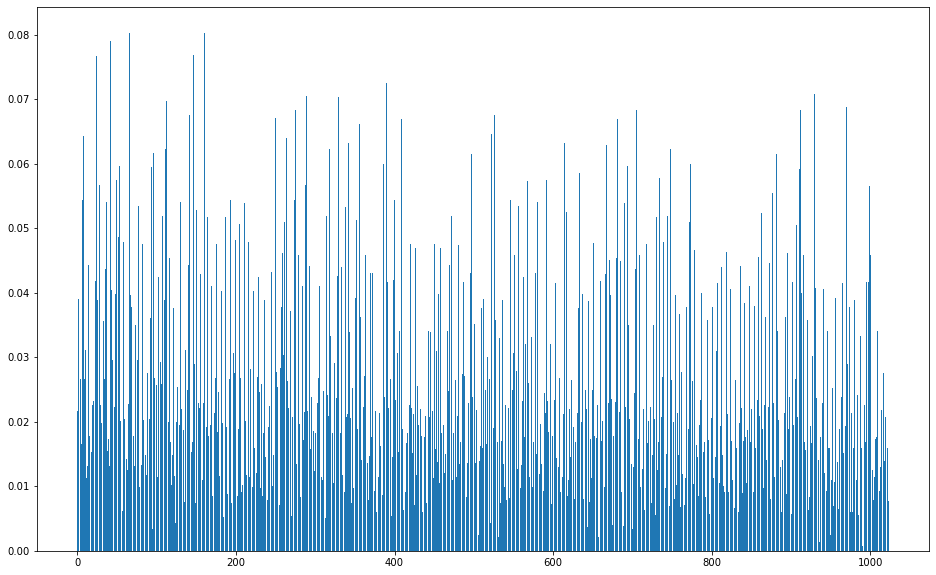

[[0 0 1 0 1 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 1 0]
 [0 0 0 0 1 0 1 0 1 0]
 [0 0 1 1 0 0 1 0 0 0]
 [0 0 1 0 0 1 0 0 1 0]
 [0 0 0 0 0 1 1 0 0 0]
 [0 1 1 0 0 0 0 1 1 0]
 [0 1 0 0 0 0 1 1 0 0]]
$$$$$$$$$$$$$$$$$$$$$
syndrome: [1 1 1 0]

 Runningtime :  1336.7571640014648 sec


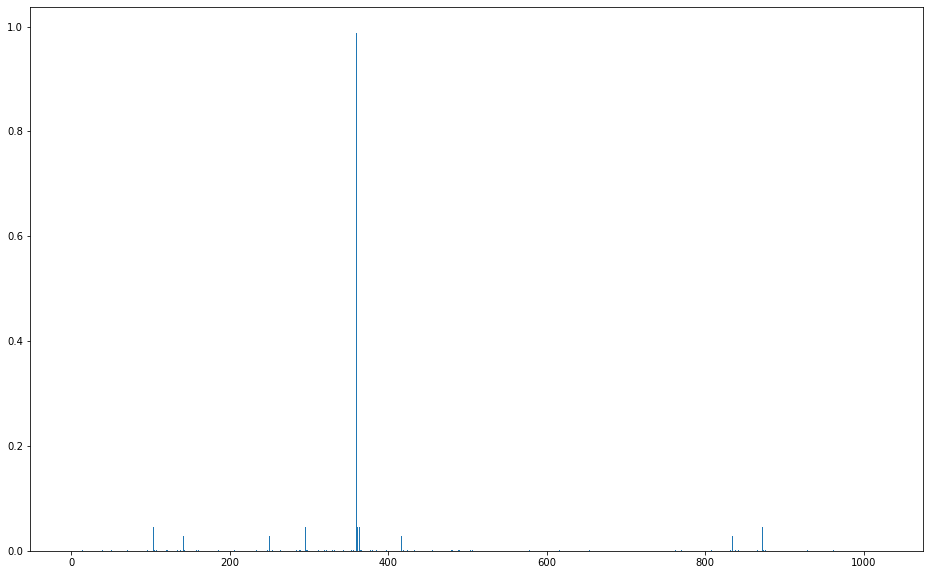

[[0 1 0 1 1 0 1 0 0 0]
 [0 1 0 1 1 1 1 0 0 0]
 [0 0 0 1 1 0 1 0 0 0]
 [0 1 1 1 1 0 1 0 0 0]
 [0 1 0 1 1 0 1 0 1 0]
 [0 1 0 1 1 0 1 1 0 0]
 [0 1 0 1 0 0 1 0 0 0]
 [0 1 0 0 1 0 1 0 0 0]]
$$$$$$$$$$$$$$$$$$$$$
syndrome: [1 1 1 1]

 Runningtime :  1347.9094140529633 sec


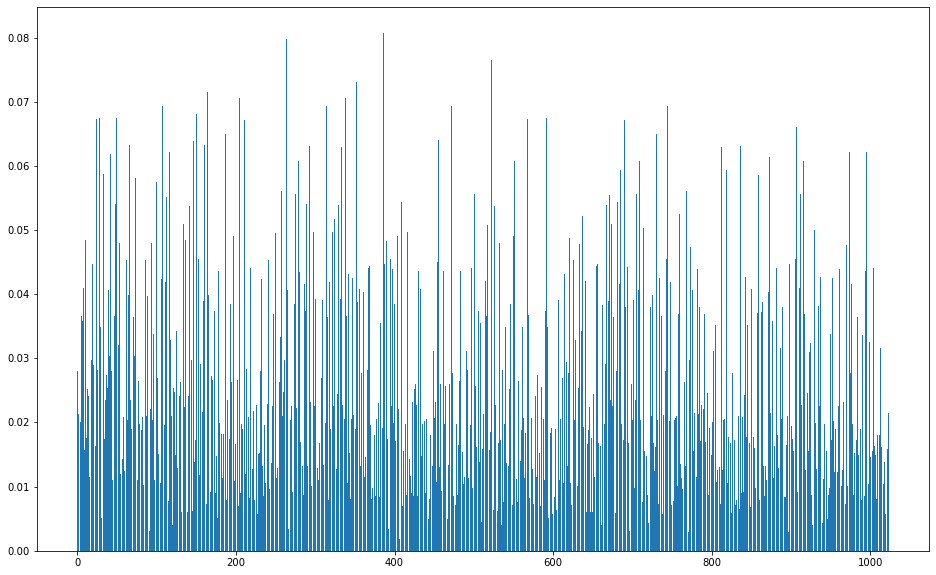

[[0 1 1 0 0 0 0 0 1 0]
 [0 1 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 1 1]
 [1 0 1 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 1 0 0 1]
 [1 0 0 0 0 0 1 0 1 0]
 [0 1 0 1 1 0 0 0 0 0]
 [0 0 0 1 0 0 0 1 1 0]]
$$$$$$$$$$$$$$$$$$$$$


IndexError: index 16 is out of bounds for axis 0 with size 16

In [5]:
gamma = []
beta = []
syndrome = []

num = int(M.shape[1]/2)

min_weight_term = np.kron(min_weight(num),tensorI(num)) + np.kron(tensorI(num),min_weight(num))

for t in range(2**(M.shape[0])):    
    p = 0.5
    n = M.shape[1]
    syndr = basis(4)[t]
    C = (sum((1-2*syndr[a])*Cjk_generator(M[a]) for a in range(M.shape[0]))) + p * min_weight_term
    B = B_generator(M.shape[1])
    s = init_s(n)
    s_d = (s).T
    print('syndrome:',syndr)
    #print("the number of basis",k+1)

    #run the program
    start_time = time.time()
    step_size   = 0.1
    result_array = np.zeros(shape=(int(3.14/step_size)+1, int(3.14/step_size)+1))
    a_gamma         = np.arange(0, np.pi, step_size)
    a_beta          = np.arange(0, np.pi, step_size)

    f_p_max = 0
    f_p_max_gamma = 0
    f_p_max_beta = 0
    f_psum = 0

    for i in range(0, int(3.14/step_size)+1):           # i for a_gamma
        for j in range(0, int(3.14/step_size)+1):       # j for a_beta

            #Construct U_C
            U_C = np.asmatrix(expm(-1j*2*a_gamma[i]*C))
            #Construct U_B
            U_B = expm(-1j*a_beta[j]*B)


            #Construct expection of each subgraph
            state = (U_B.dot(U_C)).dot(s).reshape(pow(2,n),1) # ket
            state_d = (state.conjugate()).T # bra


            f_p = (state_d.dot(C)).dot(state)
            f_psum += f_p

            if f_p.real > f_p_max:
                f_p_max = f_p.real
                f_p_max_gamma = a_gamma[i]
                f_p_max_beta = a_beta[j]

            result_array[i][j] = f_p.real
#         print("\n Average expectation using QAOA with fine grid : ",(f_psum/pow(len(a_gamma),2)).real)       
#         print("\n Maximum expectation using QAOA with fine grid : ",f_p_max)
#         print("\n Optimal gamma : ",f_p_max_gamma)
#         print("\n Optimal beta : ",f_p_max_beta)


    end_time = time.time()
    print("\n Runningtime : ",end_time - start_time,"sec")
    r = np.ones(2**M.shape[1])/(np.sqrt(2**M.shape[1]))
    #Construct U_C
    U_C = np.asmatrix(expm(-1j*2*f_p_max_gamma*C))
    #Construct U_B
    U_B = expm(-1j*f_p_max_beta*B)
    gamma.append(f_p_max_gamma)
    beta.append(f_p_max_beta)

    #Construct expection of each subgraph
    state = (U_B.dot(U_C)).dot(r).reshape(pow(2,n),1) # ket
    prob=[]
    for i in range(len(state)):
        p = np.sqrt((state[i].real)**2 + (state[i].imag)**2)
        np.array(prob.append(float(p)))      
    e = np.max(prob)
    plt.rcParams['figure.figsize'] = [16, 10]
    plt.bar(range(0, len(state)),prob)
    plt.show()
    max_number = heapq.nlargest(8, prob) 
    max_index = []
    for t in max_number:
        index = prob.index(t)
        max_index.append(index)
        prob[index] = 0

    # print(max_number)
    # print(max_index)
    Ba = basis(n)
    word = []
    for a in range(len(max_index)):
        word.append(Ba[(max_index[a])])
    print(np.array(word))
    print('$$$$$$$$$$$$$$$$$$$$$')

In [6]:
d = {'gamma': gamma,'beta ': beta}
df = pd.DataFrame(data = d)
df

,gamma,beta
0,0.2,0.2
1,0.2,0.2
2,0.8,2.4
3,0.2,0.2
4,0.2,0.2
5,0.2,0.2
6,0.2,0.2
7,0.2,0.2
8,0.8,2.4
9,0.2,0.2


## QAOA p = 0.4

syndrome: [0 0 0 0]

 Runningtime :  1346.385832309723 sec


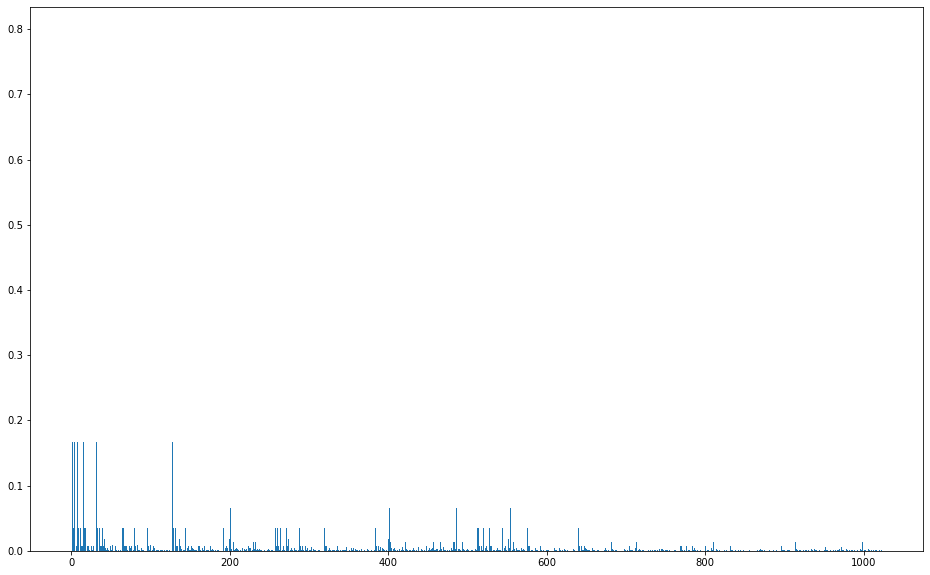

[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]]
$$$$$$$$$$$$$$$$$$$$$
syndrome: [0 0 0 1]

 Runningtime :  1342.588463306427 sec


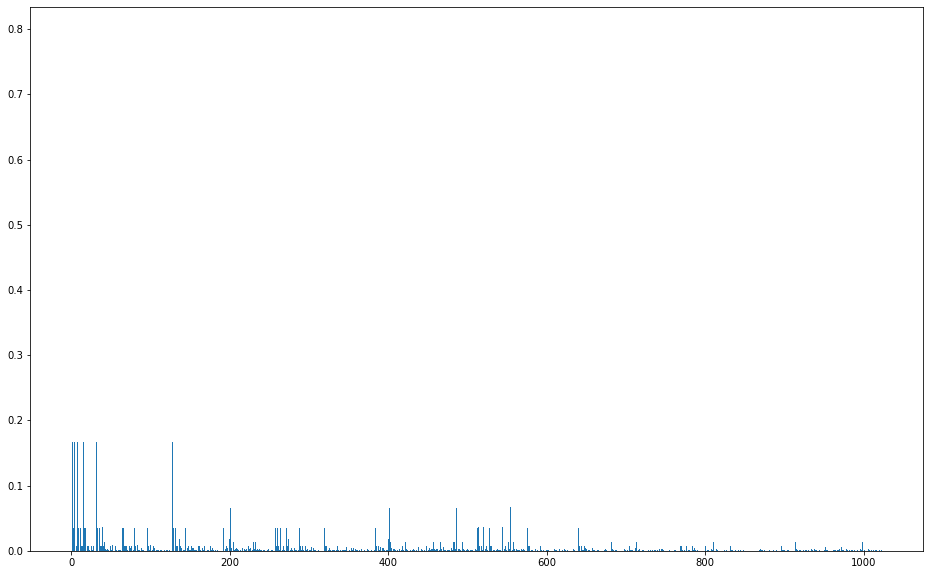

[[0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 1 0 0 0]]
$$$$$$$$$$$$$$$$$$$$$
syndrome: [0 0 1 0]

 Runningtime :  1342.2279875278473 sec


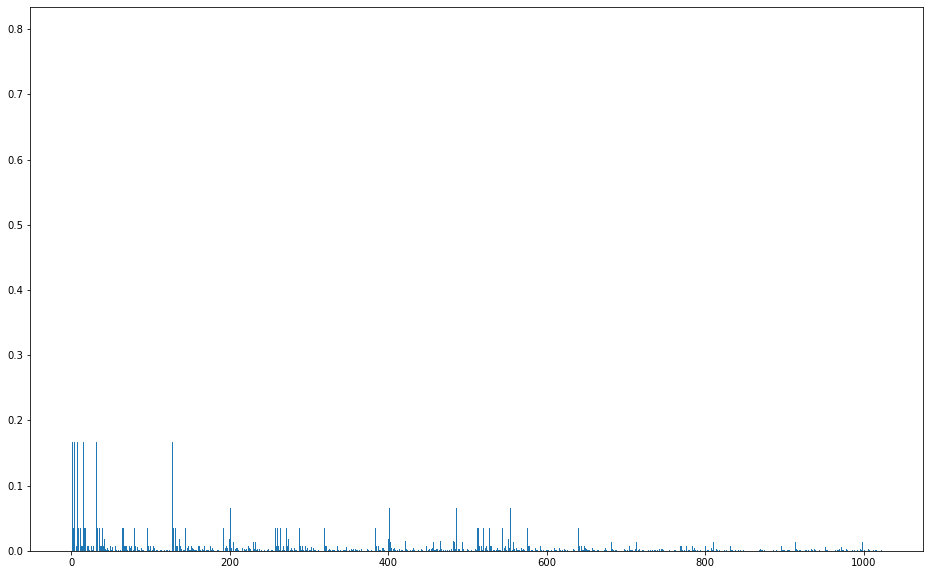

[[0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 1 0 0 0 0 0]]
$$$$$$$$$$$$$$$$$$$$$
syndrome: [0 0 1 1]

 Runningtime :  1339.8737080097198 sec


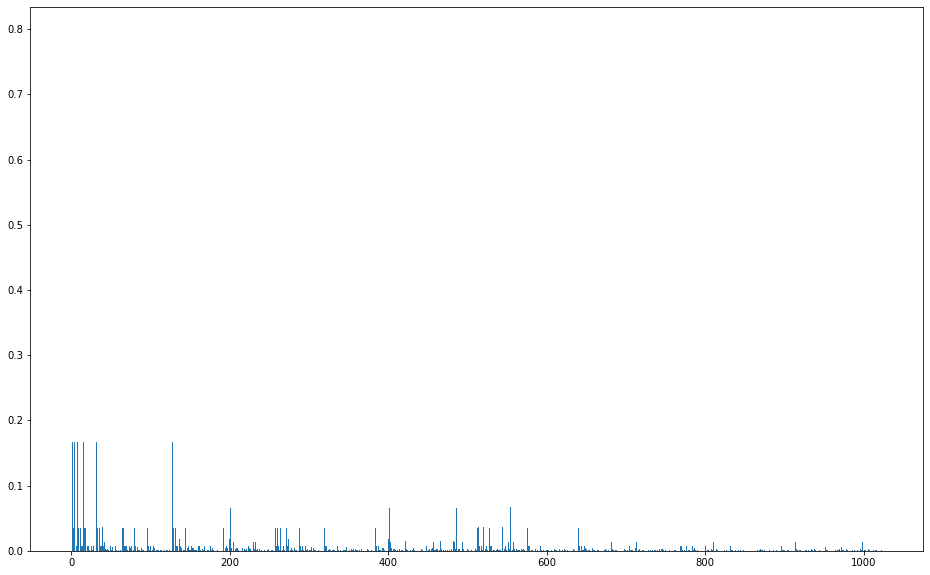

[[0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1 0 0 0]]
$$$$$$$$$$$$$$$$$$$$$
syndrome: [0 1 0 0]

 Runningtime :  1341.0742630958557 sec


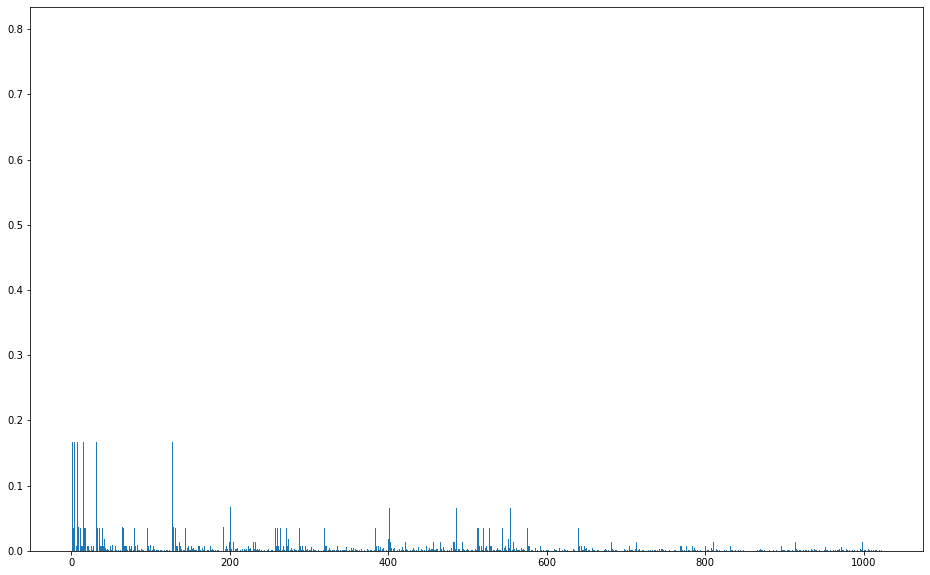

[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 1 0 0 0]]
$$$$$$$$$$$$$$$$$$$$$
syndrome: [0 1 0 1]

 Runningtime :  1341.2122311592102 sec


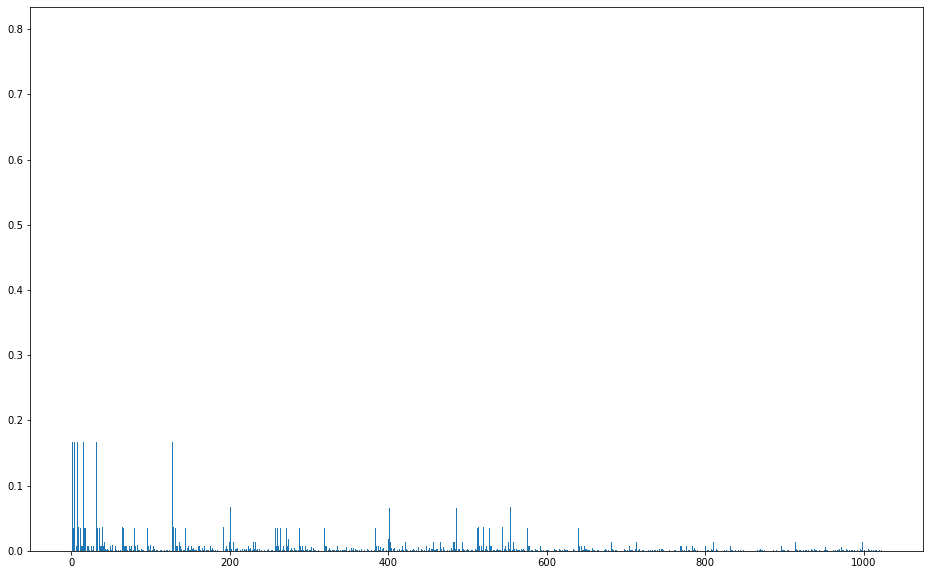

[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]]
$$$$$$$$$$$$$$$$$$$$$
syndrome: [0 1 1 0]

 Runningtime :  1340.8912801742554 sec


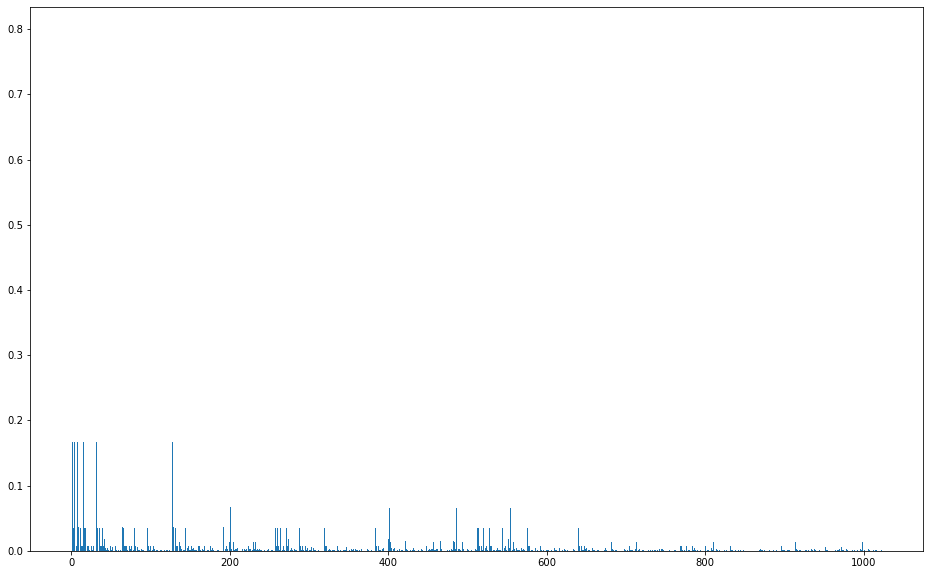

[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]]
$$$$$$$$$$$$$$$$$$$$$
syndrome: [0 1 1 1]

 Runningtime :  1345.5747656822205 sec


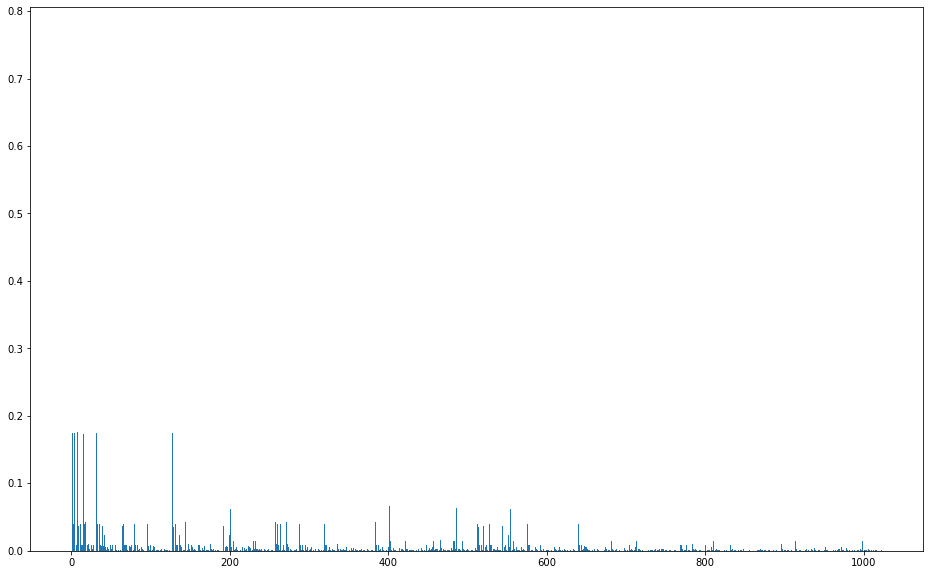

[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 1 0 0 0 0 0 0 0]]
$$$$$$$$$$$$$$$$$$$$$
syndrome: [1 0 0 0]

 Runningtime :  1340.0402030944824 sec


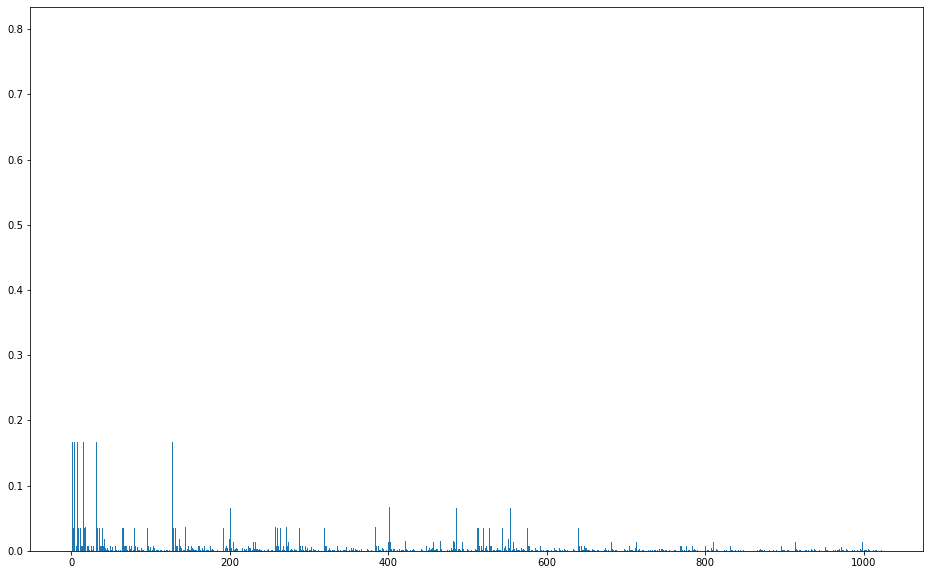

[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]]
$$$$$$$$$$$$$$$$$$$$$
syndrome: [1 0 0 1]

 Runningtime :  1339.9332268238068 sec


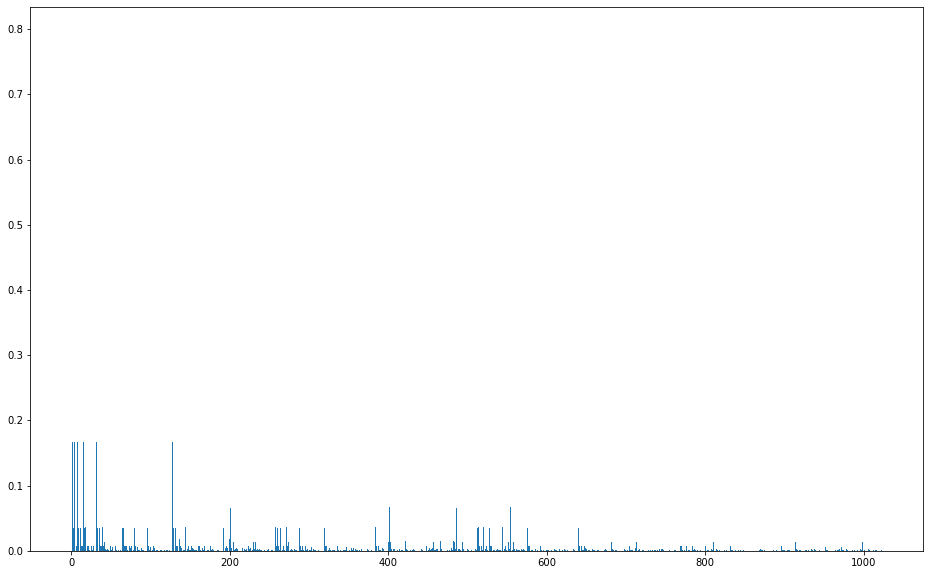

[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]]
$$$$$$$$$$$$$$$$$$$$$
syndrome: [1 0 1 0]

 Runningtime :  1342.5047955513 sec


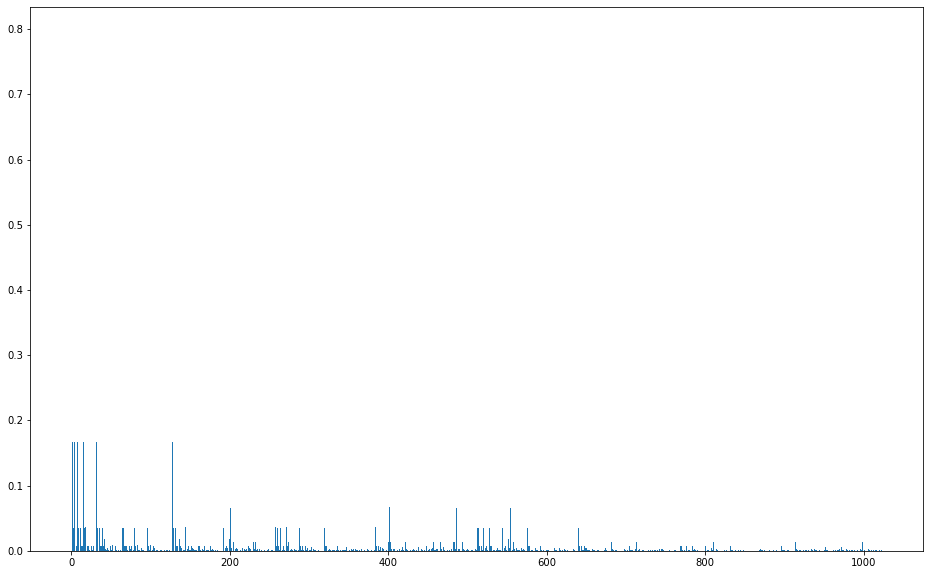

[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 1 0 0 0 0 0 0 0]]
$$$$$$$$$$$$$$$$$$$$$
syndrome: [1 0 1 1]

 Runningtime :  1343.1538760662079 sec


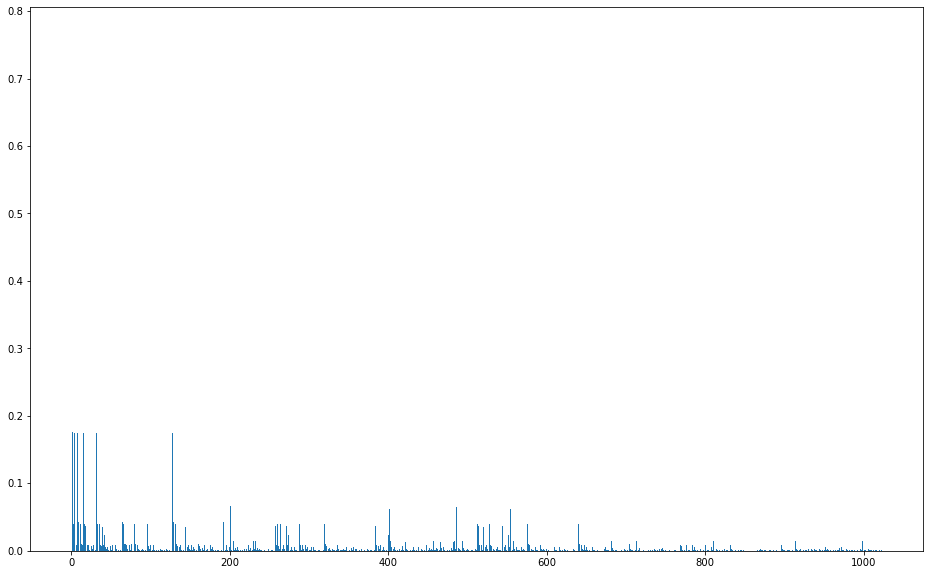

[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]]
$$$$$$$$$$$$$$$$$$$$$
syndrome: [1 1 0 0]

 Runningtime :  1342.1396913528442 sec


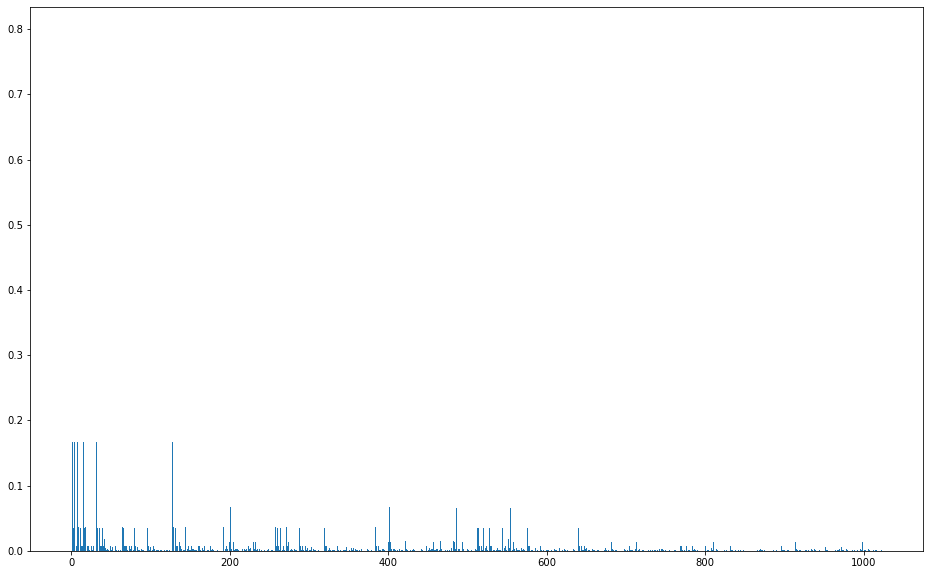

[[0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 1 0 0 0 0 0 0 0 0]]
$$$$$$$$$$$$$$$$$$$$$
syndrome: [1 1 0 1]

 Runningtime :  1340.8573777675629 sec


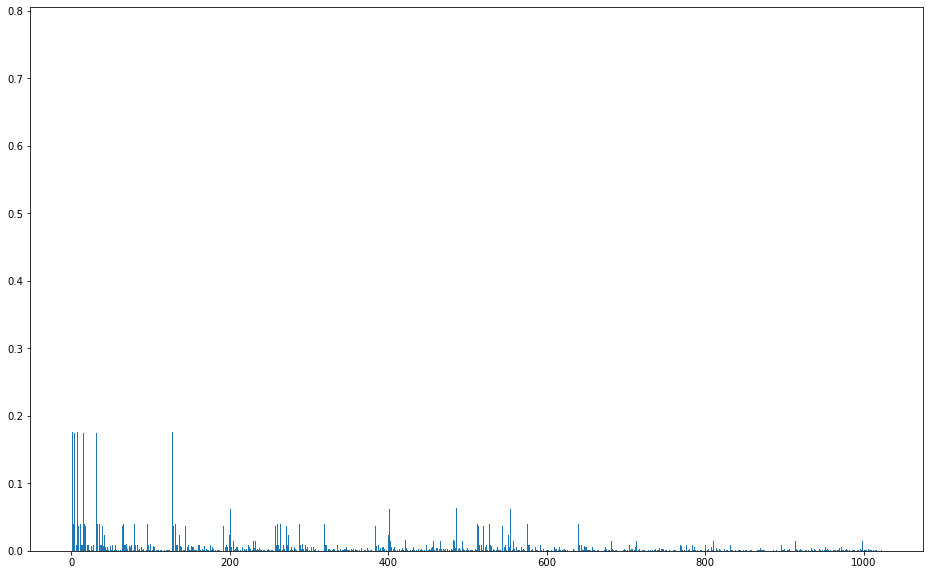

[[0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]]
$$$$$$$$$$$$$$$$$$$$$
syndrome: [1 1 1 0]

 Runningtime :  1340.5865976810455 sec


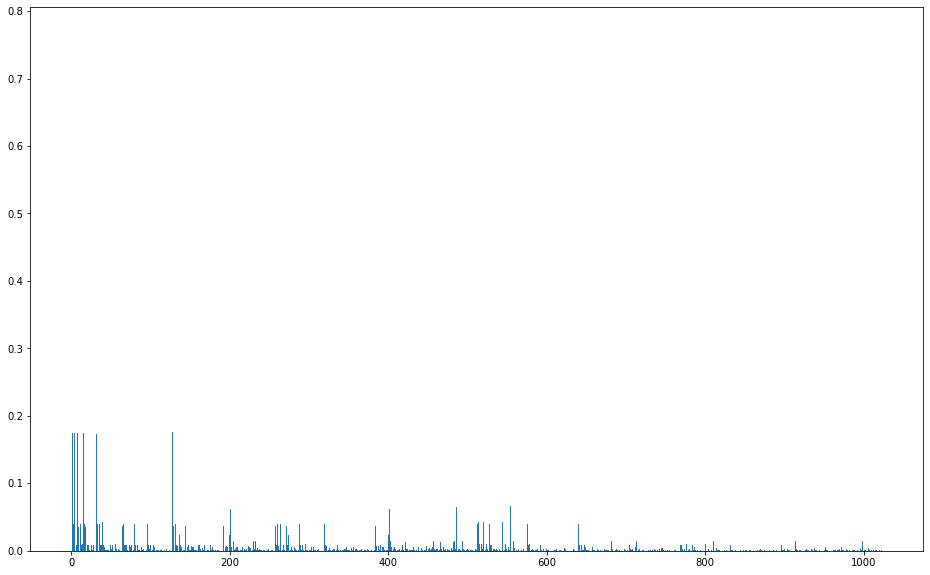

[[0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 1 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]]
$$$$$$$$$$$$$$$$$$$$$
syndrome: [1 1 1 1]

 Runningtime :  1344.1373052597046 sec


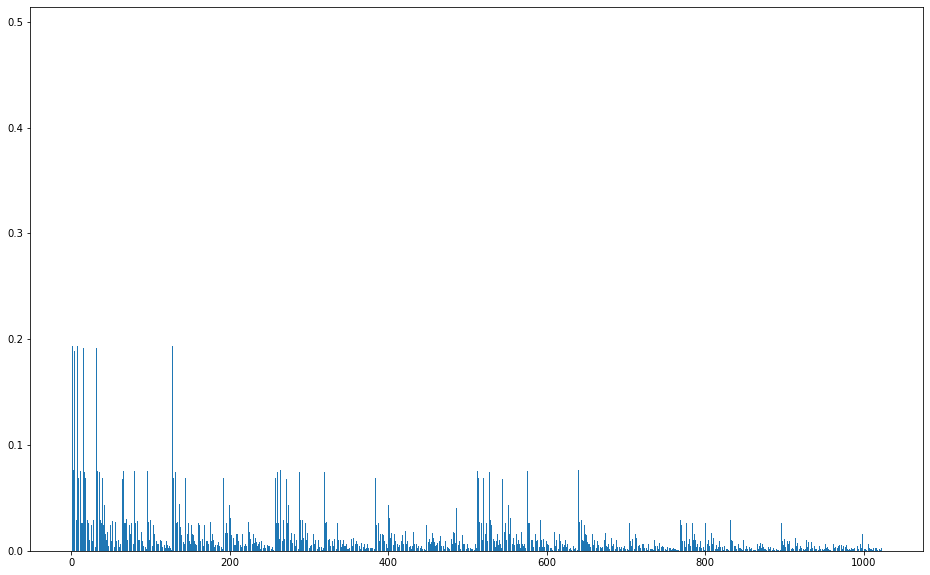

[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]]
$$$$$$$$$$$$$$$$$$$$$


In [6]:
gamma = []
beta = []
syndrome = []

num = int(M.shape[1]/2)

min_weight_term = np.kron(min_weight(num),tensorI(num)) + np.kron(tensorI(num),min_weight(num))

for t in range(2**(M.shape[0])):    
    p = 0.6
    n = M.shape[1]
    syndr = basis(4)[t]
    C = (sum((1-2*syndr[a])*Cjk_generator(M[a]) for a in range(M.shape[0]))) + p * min_weight_term
    B = B_generator(M.shape[1])
    s = init_s(n)
    s_d = (s).T
    print('syndrome:',syndr)
    #print("the number of basis",k+1)

    #run the program
    start_time = time.time()
    step_size   = 0.1
    result_array = np.zeros(shape=(int(3.14/step_size)+1, int(3.14/step_size)+1))
    a_gamma         = np.arange(0, np.pi, step_size)
    a_beta          = np.arange(0, np.pi, step_size)

    f_p_max = 0
    f_p_max_gamma = 0
    f_p_max_beta = 0
    f_psum = 0

    for i in range(0, int(3.14/step_size)+1):           # i for a_gamma
        for j in range(0, int(3.14/step_size)+1):       # j for a_beta

            #Construct U_C
            U_C = np.asmatrix(expm(-1j*2*a_gamma[i]*C))
            #Construct U_B
            U_B = expm(-1j*a_beta[j]*B)


            #Construct expection of each subgraph
            state = (U_B.dot(U_C)).dot(s).reshape(pow(2,n),1) # ket
            state_d = (state.conjugate()).T # bra


            f_p = (state_d.dot(C)).dot(state)
            f_psum += f_p

            if f_p.real > f_p_max:
                f_p_max = f_p.real
                f_p_max_gamma = a_gamma[i]
                f_p_max_beta = a_beta[j]

            result_array[i][j] = f_p.real
#         print("\n Average expectation using QAOA with fine grid : ",(f_psum/pow(len(a_gamma),2)).real)       
#         print("\n Maximum expectation using QAOA with fine grid : ",f_p_max)
#         print("\n Optimal gamma : ",f_p_max_gamma)
#         print("\n Optimal beta : ",f_p_max_beta)


    end_time = time.time()
    print("\n Runningtime : ",end_time - start_time,"sec")
    r = np.ones(2**M.shape[1])/(np.sqrt(2**M.shape[1]))
    #Construct U_C
    U_C = np.asmatrix(expm(-1j*2*f_p_max_gamma*C))
    #Construct U_B
    U_B = expm(-1j*f_p_max_beta*B)
    gamma.append(f_p_max_gamma)
    beta.append(f_p_max_beta)

    #Construct expection of each subgraph
    state = (U_B.dot(U_C)).dot(r).reshape(pow(2,n),1) # ket
    prob=[]
    for i in range(len(state)):
        p = np.sqrt((state[i].real)**2 + (state[i].imag)**2)
        np.array(prob.append(float(p)))      
    e = np.max(prob)
    plt.rcParams['figure.figsize'] = [16, 10]
    plt.bar(range(0, len(state)),prob)
    plt.show()
    max_number = heapq.nlargest(8, prob) 
    max_index = []
    for t in max_number:
        index = prob.index(t)
        max_index.append(index)
        prob[index] = 0

    # print(max_number)
    # print(max_index)
    Ba = basis(n)
    word = []
    for a in range(len(max_index)):
        word.append(Ba[(max_index[a])])
    print(np.array(word))
    print('$$$$$$$$$$$$$$$$$$$$$')

In [7]:
d = {'gamma': gamma,'beta ': beta}
df = pd.DataFrame(data = d)
df

,gamma,beta
0,3.1,0.8
1,3.1,0.8
2,3.1,0.8
3,3.1,0.8
4,3.1,0.8
5,3.1,0.8
6,3.1,0.8
7,3.1,0.7
8,3.1,0.8
9,3.1,0.8


## Apply full rank matirx

In [16]:
H_oringin = np.array([[1,0,0,1,0,0,1,1,0,0],[0,1,0,0,1,0,0,1,1,0],[0,0,1,1,0,0,1,1,1,1],[0,1,0,1,0,1,0,0,0,1]])
H_oringinT = H_oringin.T
print(H_oringin)
L = Lambda(5)

FullRank_P = np.array([[1,0,1,0],[1,0,1,1],[0,1,1,0],[0,0,1,1]])



print(matrix_rank(FullRank_P))


H = matrix_binary(FullRank_P.dot(H_oringin))
print(H)


M = H.dot(L)

x = np.array([1,0,0,0,1,1,1,0,1,1])
err = []
for i in range(10):
    l = np.zeros(10)
    l[i] = 1
    err.append(l)
for i in range(5):
    l = np.zeros(10)
    l[i] = 1
    l[i+5] = 1
    err.append(l)
err = np.array(err)

error_syndrome = []
for i in range(len(err)):
    sy = row_binary(M.dot((x + err[i]).T))
    print('\nerror: ',err[i])
    print('syndrome: ',sy)

[[1 0 0 1 0 0 1 1 0 0]
 [0 1 0 0 1 0 0 1 1 0]
 [0 0 1 1 0 0 1 1 1 1]
 [0 1 0 1 0 1 0 0 0 1]]
4
[[1 0 1 0 0 0 0 0 1 1]
 [1 1 1 1 0 1 0 0 1 0]
 [0 1 1 1 1 0 1 0 0 1]
 [0 1 1 0 0 1 1 1 1 0]]
[[0 0 0 1 1 1 0 1 0 0]
 [1 0 0 1 0 1 1 1 1 0]
 [0 1 0 0 1 0 1 1 1 1]
 [1 1 1 1 0 0 1 1 0 0]]

error:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
syndrome:  [0. 1. 0. 1.]

error:  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
syndrome:  [0. 0. 1. 1.]

error:  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
syndrome:  [0. 0. 0. 1.]

error:  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
syndrome:  [1. 1. 0. 1.]

error:  [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
syndrome:  [1. 0. 1. 0.]

error:  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
syndrome:  [1. 1. 0. 0.]

error:  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
syndrome:  [0. 1. 1. 1.]

error:  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
syndrome:  [1. 1. 1. 1.]

error:  [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
syndrome:  [0. 1. 1. 0.]

error:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
syndrome:  [0. 0. 1. 0.]

error:  [1. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
syndrome:  [1. 0. 

In [ ]:

gamma = []
beta = []
syndrome = []

num = int(M.shape[1]/2)

min_weight_term = np.kron(min_weight(num),tensorI(num)) + np.kron(tensorI(num),min_weight(num))



for t in range(2**(M.shape[1])):    
    p = 2
    n = M.shape[1]
    syndr = basis(4)[t]
    C = p * (sum((1-2*syndr[a])*Cjk_generator(M[a]) for a in range(M.shape[0]))) + min_weight_term
    B = B_generator(M.shape[1])
    s = init_s(n)
    s_d = (s).T
    print('syndrome:',syndr)
    #print("the number of basis",k+1)

    #run the program
    start_time = time.time()
    step_size   = 0.1
    result_array = np.zeros(shape=(int(3.14/step_size)+1, int(3.14/step_size)+1))
    a_gamma         = np.arange(0, np.pi, step_size)
    a_beta          = np.arange(0, np.pi, step_size)

    f_p_max = 0
    f_p_max_gamma = 0
    f_p_max_beta = 0
    f_psum = 0

    for i in range(0, int(3.14/step_size)+1):           # i for a_gamma
        for j in range(0, int(3.14/step_size)+1):       # j for a_beta

            #Construct U_C
            U_C = np.asmatrix(expm(-1j*2*a_gamma[i]*C))
            #Construct U_B
            U_B = expm(-1j*a_beta[j]*B)


            #Construct expection of each subgraph
            state = (U_B.dot(U_C)).dot(s).reshape(pow(2,n),1) # ket
            state_d = (state.conjugate()).T # bra


            f_p = (state_d.dot(C)).dot(state)
            f_psum += f_p
            
            if f_p.real > f_p_max:
                f_p_max = f_p.real
                f_p_max_gamma = a_gamma[i]
                f_p_max_beta = a_beta[j]

            result_array[i][j] = f_p.real
#     print("\n Average expectation using QAOA with fine grid : ",(f_psum/pow(len(a_gamma),2)).real)       
#     print("\n Maximum expectation using QAOA with fine grid : ",f_p_max)
#     print("\n Optimal gamma : ",f_p_max_gamma)
#     print("\n Optimal beta : ",f_p_max_beta)


    end_time = time.time()
    print("\n Runningtime : ",end_time - start_time,"sec")
    r = np.ones(2**M.shape[1])/(np.sqrt(2**M.shape[1]))
    #Construct U_C
    U_C = np.asmatrix(expm(-1j*2*f_p_max_gamma*C))
    #Construct U_B
    U_B = expm(-1j*f_p_max_beta*B)
    gamma.append(f_p_max_gamma)
    beta.append(f_p_max_beta)

    #Construct expection of each subgraph
    state = (U_B.dot(U_C)).dot(r).reshape(pow(2,n),1) # ket
    prob=[]
    for i in range(len(state)):
        p = np.sqrt((state[i].real)**2 + (state[i].imag)**2)
        np.array(prob.append(float(p)))      
    e = np.max(prob)
    plt.rcParams['figure.figsize'] = [16, 10]
    plt.bar(range(0, len(state)),prob)
    plt.show()
    max_number = heapq.nlargest(8, prob) 
    max_index = []
    for t in max_number:
        index = prob.index(t)
        max_index.append(index)
        prob[index] = 0

    # print(max_number)
    # print(max_index)
    Ba = basis(n)
    word = []
    for a in range(len(max_index)):
        word.append(Ba[(max_index[a])])
    print(np.array(word))
    print('$$$$$$$$$$$$$$$$$$$$$')